In [1]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from pathlib import Path

import pandas as pd
import numpy as np

import scipy
from scipy import optimize, integrate
from scipy import interpolate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import container
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import time
import math
import random
import multiprocessing as mp
import os
import subprocess
from shutil import copyfile

from modules_ns_bim_spherical.geometry import *
from modules_ns_bim_spherical.hybrid_model_oc_v1 import *
from modules_ns_bim_spherical.numerical_Derjaguin_v1 import *
from modules_ns_bim_spherical.oc_plots_v1 import *
from modules_ns_bim_spherical.orthogonal_collocation_v1 import *
from modules_ns_bim_spherical.v2_ns_bim_helper_plus import *
from modules_ns_bim_spherical.monte_carlo_functions import *

# # The right way to work, from now on; the above is only used because I previously 
# # used the bad namespace practice
# from modules_ns_bim_spherical import geometry
# from modules_ns_bim_spherical import hybrid_model_oc_v1
# from modules_ns_bim_spherical import numerical_Derjaguin_v1
# from modules_ns_bim_spherical import oc_plots_v1
# from modules_ns_bim_spherical import orthogonal_collocation_v1
# from modules_ns_bim_spherical import v2_ns_bim_helper_plus
## Or just:  import modules_ns_bim_spherical as XXX, then use as XXX.geometry.whatever()


In [3]:
def get_ion_str_from_protein_name(protein):
    ind_slice = protein.rfind('_') + 1
    return int(protein[ind_slice:])/1000


### Resin data

In [4]:
surf_dens_seph = 3.413e-6 # [mol m-2]
surf_dens_caq  = 3.016e-6
surf_dens_phq  = 2.55e-6
surf_dens_pxq  = 3.72e-6

sigma_seph = -1.0 * surf_dens_seph * constants().F # [C m-2]
sigma_caq  = surf_dens_caq * constants().F
sigma_phq  = surf_dens_phq * constants().F
sigma_pxq  = surf_dens_pxq * constants().F

print(sigma_seph, sigma_caq, sigma_phq, sigma_pxq)

-0.329303305 0.29099876 0.24603675000000003 0.35892419999999997


### Protein data, adh_pH_7_v4 is the biological assembly 1

In [5]:
ns_bim_dir      = 'ns_bim_programs/'
protein_folders = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7', 'lys_pH_5', 'lys_pH_7',
                   'lys_pH_9', 'ova_pH_7']

protein_masses_Da           = [149540, 36750, 233120, 14390, 14390, 14390, 43000]
protein_spec_vol_cm3_per_g  = [0.769, 0.75, 0.73, 0.702, 0.702, 0.702, 0.75]

protein_eq_vol_radii_nm = []
for ind, m in enumerate(protein_masses_Da):
    v = protein_spec_vol_cm3_per_g[ind]
    protein_eq_vol_radii_nm.append((0.75/np.pi*m*v/constants().Na)**(1/3)*1.0e7)

ion_str_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# print(protein_eq_vol_radii_nm)

### Run NS-BIM at the specified equivalent sphere volumes and ionic strengths

In [6]:
# for ion_str in ion_str_list:
#     for ind, protein in enumerate(protein_folders): 
#         radius_new   = protein_eq_vol_radii_nm[ind]
#         prot_dir     = 'ns_bim_spherical/ns_bim_programs/' + protein + '/'
#         new_folder   = 'ns_bim_spherical/results/ns_bim_data/' + protein + '_' +\
#                        str(int(ion_str*1.0e3)) + '/'

#         meta_run_ns_bim(prot_dir, radius_new, ion_str, new_folder)

## List protein data

In [7]:
nsbim_data_dir = 'ns_bim_spherical/results/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500',
 'lys_pH_5_100',
 'lys_pH_5_200',
 'lys_pH_5_300',
 'lys_pH_5_400',
 'lys_pH_5_50',
 'lys_pH_5_500',
 'lys_pH_7_100',
 'lys_pH_7_200',
 'lys_pH_7_300',
 'lys_pH_7_400',
 'lys_pH_7_50',
 'lys_pH_7_500',
 'lys_pH_9_100',
 'lys_pH_9_200',
 'lys_pH_9_300',
 'lys_pH_9_400',
 'lys_pH_9_50',
 'lys_pH_9_500',
 'ova_pH_7_100',
 'ova_pH_7_200',
 'ova_pH_7_300',
 'ova_pH_7_400',
 'ova_pH_7_50',
 'ova_pH_7_500']

In [9]:
# elements_dict, node_dict, charge_dict = get_elem_and_node_dicts(nsbim_data_dir, protein_folders)
# elements_dict = fill_elem_dict(elements_dict, node_dict, protein_folders)

### Perform geometry calculations and generate integrand results, using the constant surface potential boundary condition

In [10]:
# integrand_dir  = 'ns_bim_spherical/results/integrand_results/'
# energy_dir     = 'ns_bim_spherical/results/energy_results/'

# resin_list = ['caq', 'phq', 'pxq']

# for resin in resin_list:
#     for protein in protein_folders:

#         if protein[:3] == 'lys':
#             pass
#         else:
#             start_time = time.time()
            
#             elements_df = elements_dict[protein]
#             ion_str     = get_ion_str_from_protein_name(protein)
#             sol         = bulk_solution(ion_str)

#             kap_h_min   = 0.1
#             kap_h_mid   = 1.2
#             kap_h_max   = 9.0
#             z_min       = kap_h_min/sol.kappa # [m]
#             z_mid       = kap_h_mid/sol.kappa
#             z_max       = kap_h_max/sol.kappa
#             zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
#                                  np.linspace(z_mid, z_max, 21)))

#             energy_map_file = 'oc_energy_maps/' + resin + '_' +\
#             str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
#             energy_fun      = get_interp_fun(energy_map_file)

#             args_list = [(i, elements_df, zs, energy_fun, sol) for i\
#                          in elements_df.index]
#             pool      = mp.Pool(processes = mp.cpu_count())
#             results   = pool.map(get_integrand_list, args_list)
#             pool.close()
#             pool.join()

#             indeces       = [res[0] for res in results]
#             integrand_res = [res[1] for res in results]
#             energy_res    = [res[2] for res in results]

#             new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
#             new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

#             file = resin + '_' + protein + '.csv'

#             new_integrand_df.to_csv(integrand_dir + file)
#             new_energy_df.to_csv(energy_dir + file)

#             print_time((time.time() - start_time)/60.0)
#             print('Completed ' + file + ' \n')


In [11]:
# resin_list = ['sep']

# for resin in resin_list:
#     for protein in protein_folders:

#         if protein[:3] != 'lys':
#             pass
#         else:
#             start_time = time.time()
            
#             elements_df = elements_dict[protein]
#             ion_str     = get_ion_str_from_protein_name(protein)
#             sol         = bulk_solution(ion_str)

#             kap_h_min   = 0.1
#             kap_h_mid   = 1.2
#             kap_h_max   = 9.0
#             z_min       = kap_h_min/sol.kappa # [m]
#             z_mid       = kap_h_mid/sol.kappa
#             z_max       = kap_h_max/sol.kappa
#             zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
#                                  np.linspace(z_mid, z_max, 21)))

#             energy_map_file = 'oc_energy_maps/' + resin + '_' +\
#             str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
#             energy_fun      = get_interp_fun(energy_map_file)

#             args_list = [(i, elements_df, zs, energy_fun, sol) for i\
#                          in elements_df.index]
#             pool      = mp.Pool(processes = mp.cpu_count())
#             results   = pool.map(get_integrand_list, args_list)
#             pool.close()
#             pool.join()

#             indeces       = [res[0] for res in results]
#             integrand_res = [res[1] for res in results]
#             energy_res    = [res[2] for res in results]

#             new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
#             new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

#             file = resin + '_' + protein + '.csv'

#             new_integrand_df.to_csv(integrand_dir + file)
#             new_energy_df.to_csv(energy_dir + file)

#             print_time((time.time() - start_time)/60.0)
#             print('Completed ' + file + ' \n')


### Keq estimate figures - one z0 for all eq vol AEX results

caq adh_pH_7
caq blg_pH_7
caq cat_pH_7
caq ova_pH_7
phq adh_pH_7
phq blg_pH_7
phq cat_pH_7
phq ova_pH_7
pxq adh_pH_7
pxq blg_pH_7
pxq cat_pH_7
pxq ova_pH_7


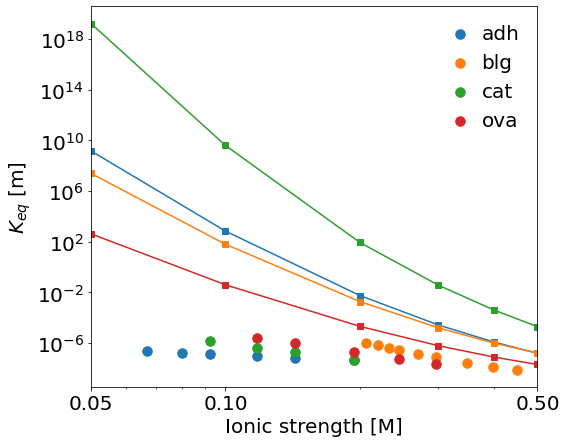

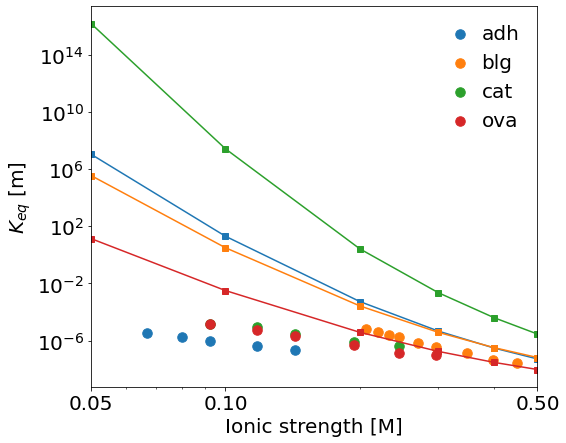

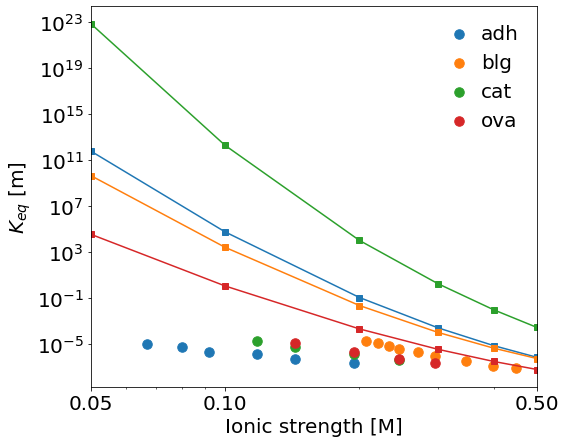

In [14]:
integrand_dir  = 'ns_bim_spherical/results/integrand_results/'
resin_list     = ['caq', 'phq', 'pxq']

z0 = 2.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')
            
            df_model = pd.DataFrame({'IS_M':xs, 'Keq_m':ys})
            df_model.to_csv(f'./ns_bim_spherical/results/Keq_results/{z0:.0e}/{resin}_{key}.csv', index=False)
            print(resin, key)

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

#     fig.savefig('ns_bim_spherical/results/images/' + resin + '_' +\
#                 str(int(round(z0*1.0e12))) + '_pm_z0.png', 
#                 bbox_inches='tight', dpi = 300)

## Keq estimate figures for one protein

sep lys_pH_5
sep lys_pH_7
sep lys_pH_9


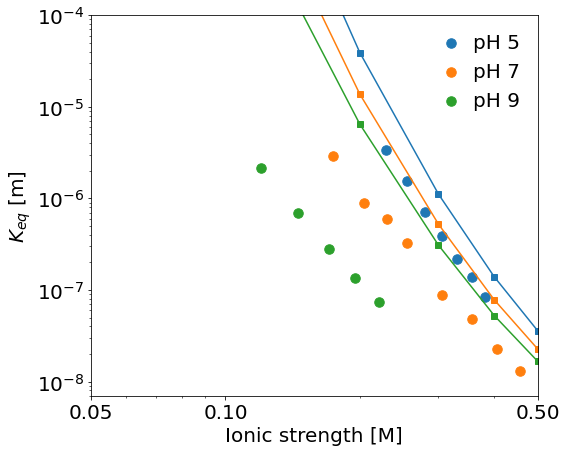

In [16]:
integrand_dir  = 'ns_bim_spherical/results/integrand_results/'
resin_list     = ['sep']

z0 = 2.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ## axs.set_ylim(7e-9, 1e-5)
    ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] != 'lys':
            pass
        else:
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] != 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')
            
            df_model = pd.DataFrame({'IS_M':xs, 'Keq_m':ys})
            df_model.to_csv(f'./ns_bim_spherical/results/Keq_results/{z0:.0e}/{resin}_{key}.csv', index=False)
            print(resin, key)

            df_exp = get_exp_data(key, resin)
            label = 'pH ' + key[-1]
            plot_exp_data_v2(ax, df_exp, label)

#     fig.savefig('ns_bim_spherical/results/images/' + resin + '_' +\
#                 str(int(round(z0*1.0e12))) + '_pm_z0.png', 
#                 bbox_inches='tight', dpi = 300)

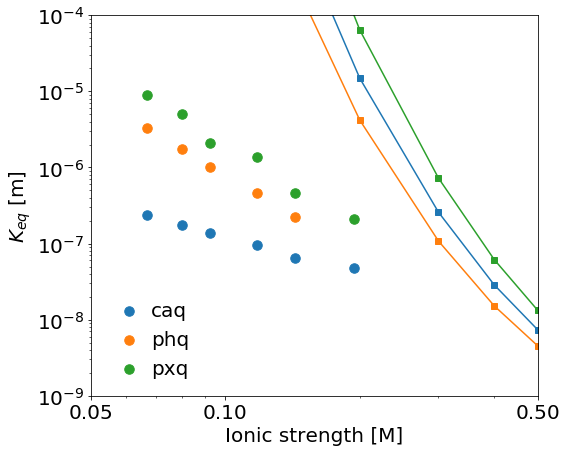

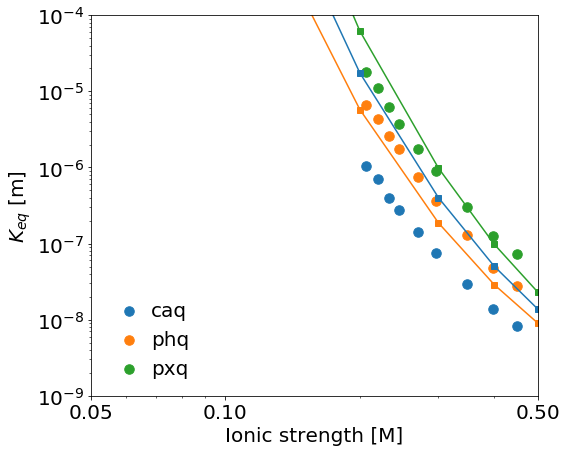

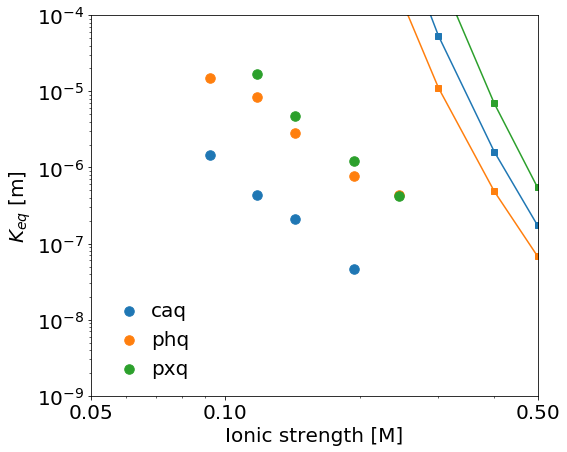

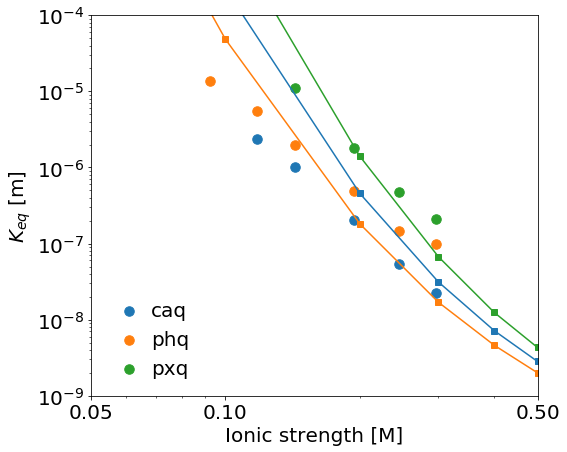

In [31]:
integrand_dir  = 'ns_bim_spherical/results/integrand_results/'
resin_list     = ['caq', 'phq', 'pxq']
pois           = ['adh', 'blg', 'cat', 'ova']
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

    
    
for poi in pois:  
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

    for resin in resin_list:
        for protein in protein_folders:
            if protein[:3] != poi:
                pass
            else:
                ion_str     = get_ion_str_from_protein_name(protein)
                integrand_df_file = resin + '_' + protein + '.csv'
                Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
                res[protein] = Keq

        for key in species_pH:
            if key[:3] != poi:
                pass
            else:

                ion_str = []
                Keq = []
                for rkey in res:
                    if rkey[:rkey.rfind('_')] == key:
                        ion_str.append(get_ion_str_from_protein_name(rkey))
                        Keq.append(res[rkey])
                order = np.argsort(ion_str)
                xs = np.array(ion_str)[order]
                ys = np.array(Keq)[order]
                ax.plot(xs, ys, 's-')

                df_exp = get_exp_data(key, resin)
                label = resin
                plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results/images/resin_comparison/' + poi +\
                '_resin_comparison_' + str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

## Calculations with constant charge BC

In [7]:
integrand_dir  = 'ns_bim_spherical/results_cc_bc/integrand_results/'
energy_dir     = 'ns_bim_spherical/results_cc_bc/energy_results/'

resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] == 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein]
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps_cc/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_total_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count()-1)
            results   = pool.map(get_integrand_list_cc, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
            new_energy_df.to_csv(energy_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


4.76
Completed caq_adh_pH_7_100.csv 

4.98
Completed caq_adh_pH_7_200.csv 

4.98
Completed caq_adh_pH_7_300.csv 

4.93
Completed caq_adh_pH_7_400.csv 

4.92
Completed caq_adh_pH_7_50.csv 

4.94
Completed caq_adh_pH_7_500.csv 

4.86
Completed caq_blg_pH_7_100.csv 

4.90
Completed caq_blg_pH_7_200.csv 

4.86
Completed caq_blg_pH_7_300.csv 

4.85
Completed caq_blg_pH_7_400.csv 

4.88
Completed caq_blg_pH_7_50.csv 

4.88
Completed caq_blg_pH_7_500.csv 

4.92
Completed caq_cat_pH_7_100.csv 

4.94
Completed caq_cat_pH_7_200.csv 

4.96
Completed caq_cat_pH_7_300.csv 

4.92
Completed caq_cat_pH_7_400.csv 

4.96
Completed caq_cat_pH_7_50.csv 

4.94
Completed caq_cat_pH_7_500.csv 

4.89
Completed caq_ova_pH_7_100.csv 

4.94
Completed caq_ova_pH_7_200.csv 

4.93
Completed caq_ova_pH_7_300.csv 

4.93
Completed caq_ova_pH_7_400.csv 

4.89
Completed caq_ova_pH_7_50.csv 

4.93
Completed caq_ova_pH_7_500.csv 

4.90
Completed phq_adh_pH_7_100.csv 

4.94
Completed phq_adh_pH_7_200.csv 

4.92
Completed p

In [8]:
integrand_dir  = 'ns_bim_spherical/results_cc_bc/integrand_results/'
energy_dir     = 'ns_bim_spherical/results_cc_bc/energy_results/'

resin_list = ['sep']

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] != 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein]
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps_cc/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_total_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count()-1)
            results   = pool.map(get_integrand_list_cc, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
            new_energy_df.to_csv(energy_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


5.07
Completed sep_lys_pH_5_100.csv 

5.03
Completed sep_lys_pH_5_200.csv 

5.06
Completed sep_lys_pH_5_300.csv 

5.08
Completed sep_lys_pH_5_400.csv 

5.04
Completed sep_lys_pH_5_50.csv 

4.99
Completed sep_lys_pH_5_500.csv 

5.00
Completed sep_lys_pH_7_100.csv 

5.02
Completed sep_lys_pH_7_200.csv 

5.03
Completed sep_lys_pH_7_300.csv 

5.06
Completed sep_lys_pH_7_400.csv 

5.03
Completed sep_lys_pH_7_50.csv 

5.02
Completed sep_lys_pH_7_500.csv 

5.04
Completed sep_lys_pH_9_100.csv 

5.05
Completed sep_lys_pH_9_200.csv 

5.02
Completed sep_lys_pH_9_300.csv 

5.03
Completed sep_lys_pH_9_400.csv 

5.07
Completed sep_lys_pH_9_50.csv 

5.02
Completed sep_lys_pH_9_500.csv 



### Keq estimate figures - constant charge BC

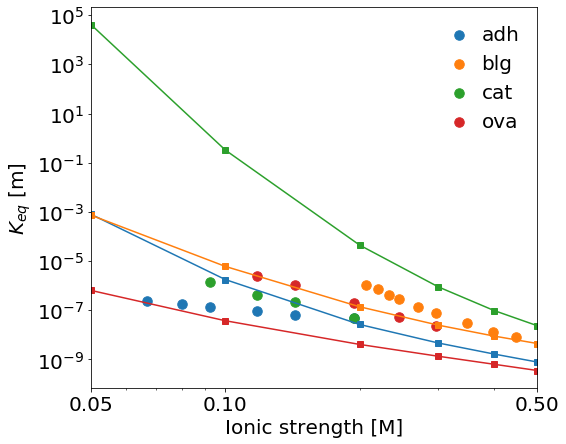

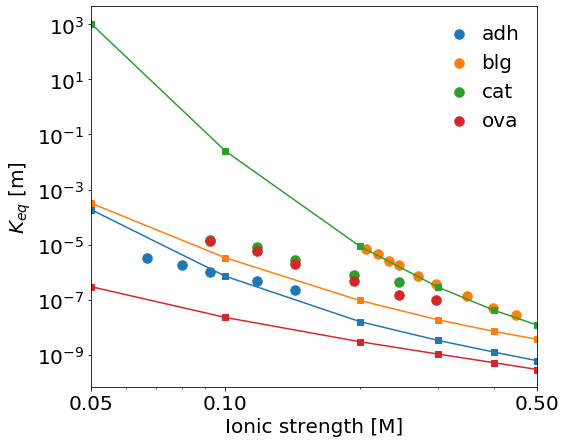

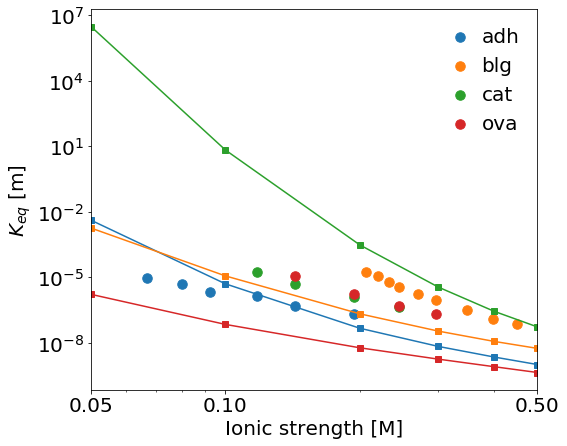

In [11]:
integrand_dir  = 'ns_bim_spherical/results_cc_bc/integrand_results/'
resin_list     = ['caq', 'phq', 'pxq']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results_cc_bc/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

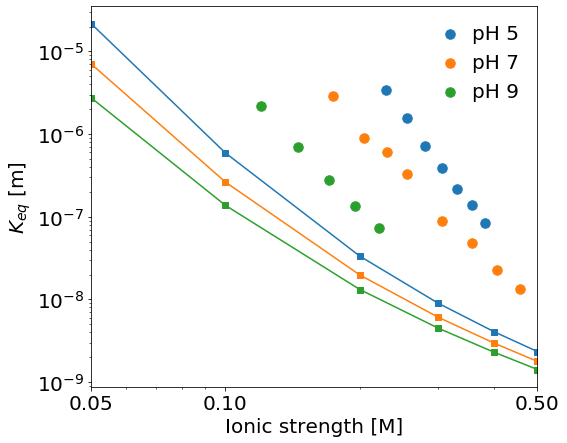

In [12]:
integrand_dir  = 'ns_bim_spherical/results_cc_bc/integrand_results/'
resin_list     = ['sep']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
    # ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] != 'lys':
            pass
        else:
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] != 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = 'pH ' + key[-1]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results_cc_bc/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

## Test linear to nonlinear surface potential mapping

In [23]:
protien = protein_folders[0]
elements_df = elements_dict[protein]
elements_df

node_1_id  node_2_id  node_3_id  potential_V  charge_C_m2     x1_nm  \
0              1         36         13    -0.002928    -0.003382  0.000000   
1             36        473         13    -0.002891    -0.003415  0.033321   
2             36         37        473    -0.001827    -0.002363  0.033321   
3             37        475        473    -0.001516    -0.002100  0.066572   
4             37         38        475    -0.000349    -0.000946  0.066572   
...          ...        ...        ...          ...          ...       ...   
11515       5760        402        401    -0.008094    -0.008320  0.020713   
11516       5760       5762        402    -0.008826    -0.009222  0.020713   
11517       5762        403        402    -0.009797    -0.010093  0.053937   
11518       5762        426        403    -0.009577    -0.009933  0.053937   
11519        426          7        403    -0.010524    -0.010980  0.087237   

          y1_nm     z1_nm     x2_nm     y2_nm     z2_nm     x3_nm     y3_nm  \
0      0.000000  2.338299  0.033321  0.102553  2.335812  0.107830  0.000000   
1      0.102553  2.335812  0.141209  0.102594  2.331776  0.107830  0.000000   
2      0.102553  2.335812  0.066572  0.204887  2.328354  0.141209  0.102594   
3      0.204887  2.328354  0.174562  0.205024  2.322743  0.141209  0.102594   
4      0.204887  2.328354  0.099681  0.306786  2.315943  0.174562  0.205024   
...         ...       ...       ...       ...       ...       ...       ...   
11515 -0.268473 -2.322743 -0.066572 -0.204887 -2.328354 -0.099681 -0.306786   
11516 -0.268473 -2.322743  0.053937 -0.166001 -2.331776 -0.066572 -0.204887   
11517 -0.166001 -2.331776 -0.033321 -0.102553 -2.335812 -0.066572 -0.204887   
11518 -0.166001 -2.331776  0.087237 -0.063381 -2.335812 -0.033321 -0.102553   
11519 -0.063381 -2.335812  0.000000  0.000000 -2.338299 -0.033321 -0.102553   

          z3_nm  x_cent_nm  y_cent_nm  z_cent_nm    n_x_nm    n_y_nm    n_z_nm  
0      2.335812   0.047051   0.034184   2.336641  0.023060  0.016754  0.999594  
1      2.335812   0.094120   0.068382   2.334466  0.037358  0.027143  0.998933  
2      2.331776   0.080367   0.136678   2.331981  0.037291  0.060573  0.997467  
3      2.331776   0.127448   0.170835   2.327625  0.051665  0.071017  0.996136  
4      2.322743   0.113605   0.238899   2.322347  0.051472  0.104253  0.993218  
...         ...        ...        ...        ...       ...       ...       ...  
11515 -2.315943  -0.048513  -0.260049  -2.322347 -0.019637 -0.114597 -0.993218  
11516 -2.328354   0.002693  -0.213120  -2.327625  0.000056 -0.087822 -0.996136  
11517 -2.328354  -0.015319  -0.157814  -2.331981 -0.005435 -0.070924 -0.997467  
11518 -2.335812   0.035951  -0.110645  -2.334466  0.014270 -0.043918 -0.998933  
11519 -2.335812   0.017972  -0.055311  -2.336641  0.008808 -0.027109 -0.999594  

[11520 rows x 20 columns]

In [24]:
sol = bulk_solution(0.1)
sol.kappa

1029771711.6526347

In [27]:
df_non = elements_df.copy()
df_non['potential_V'] = map_pot_lin_to_nonlin(elements_df['potential_V'], sol)
df_non

node_1_id  node_2_id  node_3_id  potential_V  charge_C_m2     x1_nm  \
0              1         36         13    -0.002926    -0.003382  0.000000   
1             36        473         13    -0.002889    -0.003415  0.033321   
2             36         37        473    -0.001827    -0.002363  0.033321   
3             37        475        473    -0.001516    -0.002100  0.066572   
4             37         38        475    -0.000349    -0.000946  0.066572   
...          ...        ...        ...          ...          ...       ...   
11515       5760        402        401    -0.008060    -0.008320  0.020713   
11516       5760       5762        402    -0.008783    -0.009222  0.020713   
11517       5762        403        402    -0.009739    -0.010093  0.053937   
11518       5762        426        403    -0.009522    -0.009933  0.053937   
11519        426          7        403    -0.010452    -0.010980  0.087237   

          y1_nm     z1_nm     x2_nm     y2_nm     z2_nm     x3_nm     y3_nm  \
0      0.000000  2.338299  0.033321  0.102553  2.335812  0.107830  0.000000   
1      0.102553  2.335812  0.141209  0.102594  2.331776  0.107830  0.000000   
2      0.102553  2.335812  0.066572  0.204887  2.328354  0.141209  0.102594   
3      0.204887  2.328354  0.174562  0.205024  2.322743  0.141209  0.102594   
4      0.204887  2.328354  0.099681  0.306786  2.315943  0.174562  0.205024   
...         ...       ...       ...       ...       ...       ...       ...   
11515 -0.268473 -2.322743 -0.066572 -0.204887 -2.328354 -0.099681 -0.306786   
11516 -0.268473 -2.322743  0.053937 -0.166001 -2.331776 -0.066572 -0.204887   
11517 -0.166001 -2.331776 -0.033321 -0.102553 -2.335812 -0.066572 -0.204887   
11518 -0.166001 -2.331776  0.087237 -0.063381 -2.335812 -0.033321 -0.102553   
11519 -0.063381 -2.335812  0.000000  0.000000 -2.338299 -0.033321 -0.102553   

          z3_nm  x_cent_nm  y_cent_nm  z_cent_nm    n_x_nm    n_y_nm    n_z_nm  
0      2.335812   0.047051   0.034184   2.336641  0.023060  0.016754  0.999594  
1      2.335812   0.094120   0.068382   2.334466  0.037358  0.027143  0.998933  
2      2.331776   0.080367   0.136678   2.331981  0.037291  0.060573  0.997467  
3      2.331776   0.127448   0.170835   2.327625  0.051665  0.071017  0.996136  
4      2.322743   0.113605   0.238899   2.322347  0.051472  0.104253  0.993218  
...         ...        ...        ...        ...       ...       ...       ...  
11515 -2.315943  -0.048513  -0.260049  -2.322347 -0.019637 -0.114597 -0.993218  
11516 -2.328354   0.002693  -0.213120  -2.327625  0.000056 -0.087822 -0.996136  
11517 -2.328354  -0.015319  -0.157814  -2.331981 -0.005435 -0.070924 -0.997467  
11518 -2.335812   0.035951  -0.110645  -2.334466  0.014270 -0.043918 -0.998933  
11519 -2.335812   0.017972  -0.055311  -2.336641  0.008808 -0.027109 -0.999594  

[11520 rows x 20 columns]

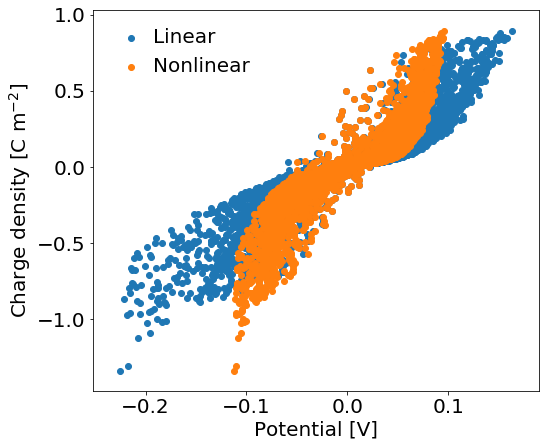

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
ax.set_xlabel('Potential [V]')
ax.set_ylabel(r'Charge density [C m$^{-2}$]')

ax.scatter(elements_df['potential_V'], elements_df['charge_C_m2'], label='Linear')
ax.scatter(df_non['potential_V'], df_non['charge_C_m2'], label='Nonlinear')
ax.legend(loc='best', frameon=False, handletextpad=0.1)
fig.savefig('ns_bim_spherical/results/images/linear_to_nonlinear_potential_mapping.png',
            bbox_inches='tight', dpi = 300)

## Calculations with constant potential boundary condition, mapping linear to nonlinear surface potentials

In [7]:
integrand_dir  = 'ns_bim_spherical/results_potential_lin_to_non_map/integrand_results/'
energy_dir     = 'ns_bim_spherical/results_potential_lin_to_non_map/energy_results/'

resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] == 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)
            elements_df['potential_V'] =\
            map_pot_lin_to_nonlin(elements_df['potential_V'], sol)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
            new_energy_df.to_csv(energy_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


2.71
Completed caq_adh_pH_7_100.csv 

2.87
Completed caq_adh_pH_7_200.csv 

2.97
Completed caq_adh_pH_7_300.csv 

2.99
Completed caq_adh_pH_7_400.csv 

3.09
Completed caq_adh_pH_7_50.csv 

3.10
Completed caq_adh_pH_7_500.csv 

3.06
Completed caq_blg_pH_7_100.csv 

3.02
Completed caq_blg_pH_7_200.csv 

3.04
Completed caq_blg_pH_7_300.csv 

3.01
Completed caq_blg_pH_7_400.csv 

2.99
Completed caq_blg_pH_7_50.csv 

3.02
Completed caq_blg_pH_7_500.csv 

3.04
Completed caq_cat_pH_7_100.csv 

3.03
Completed caq_cat_pH_7_200.csv 

3.05
Completed caq_cat_pH_7_300.csv 

3.04
Completed caq_cat_pH_7_400.csv 

3.04
Completed caq_cat_pH_7_50.csv 

3.05
Completed caq_cat_pH_7_500.csv 

3.04
Completed caq_ova_pH_7_100.csv 

3.04
Completed caq_ova_pH_7_200.csv 

3.03
Completed caq_ova_pH_7_300.csv 

3.03
Completed caq_ova_pH_7_400.csv 

3.04
Completed caq_ova_pH_7_50.csv 

3.06
Completed caq_ova_pH_7_500.csv 

3.05
Completed phq_adh_pH_7_100.csv 

3.05
Completed phq_adh_pH_7_200.csv 

3.05
Completed p

In [15]:
integrand_dir  = 'ns_bim_spherical/results_potential_lin_to_non_map/integrand_results/'
energy_dir     = 'ns_bim_spherical/results_potential_lin_to_non_map/energy_results/'

resin_list = ['sep']

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] != 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)
            elements_df['potential_V'] =\
            map_pot_lin_to_nonlin(elements_df['potential_V'], sol)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
            new_energy_df.to_csv(energy_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


3.03
Completed sep_lys_pH_5_100.csv 

3.05
Completed sep_lys_pH_5_200.csv 



Process ForkPoolWorker-2962:
Process ForkPoolWorker-2967:
Process ForkPoolWorker-2953:
Process ForkPoolWorker-2958:
Process ForkPoolWorker-2976:
Process ForkPoolWorker-2972:
Process ForkPoolWorker-2975:
Process ForkPoolWorker-2961:
Process ForkPoolWorker-2945:
Process ForkPoolWorker-2957:
Process ForkPoolWorker-2970:
Process ForkPoolWorker-2947:
Process ForkPoolWorker-2964:
Process ForkPoolWorker-2965:
Process ForkPoolWorker-2951:
Process ForkPoolWorker-2974:
Process ForkPoolWorker-2959:
Process ForkPoolWorker-2946:
Process ForkPoolWorker-2954:
Process ForkPoolWorker-2949:
Process ForkPoolWorker-2950:
Process ForkPoolWorker-2956:
Process ForkPoolWorker-2969:
Process ForkPoolWorker-2966:
Process ForkPoolWorker-2971:
Process ForkPoolWorker-2952:
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)

  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/process.py", line 

  File "/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/numerical_Derjaguin_v1.py", line 73, in get_integrand_list
    orient_df_1   = get_orientation_df(elements_df, row_plane)
  File "/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/numerical_Derjaguin_v1.py", line 86, in get_integrand_list
    orient_df_1['potential_V'].values)
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/numerical_Derjaguin_v1.py", line 73, in get_integrand_list
    orient_df_1   = get_orientation_df(elements_df, row_plane)
  File "/home/chase/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/chase/Documents

  File "/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/numerical_Derjaguin_v1.py", line 73, in get_integrand_list
    orient_df_1   = get_orientation_df(elements_df, row_plane)
  File "/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/geometry.py", line 319, in get_orientation_df
    cut(orientation_df)
  File "/home/chase/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py", line 868, in __call__
    z, ier = dfitpack.bispeu(tx, ty, c, kx, ky, x, y)
  File "/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/geometry.py", line 319, in get_orientation_df
    cut(orientation_df)
  File "/home/chase/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py", line 868, in __call__
    z, ier = dfitpack.bispeu(tx, ty, c, kx, ky, x, y)
  File "/home/chase/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py", line 976, in ev
    return self.__call__(xi, yi, dx=dx, dy=dy, grid

  File "/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 871, in __getitem__
    result = self.index.get_value(self, key)
  File "/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 4404, in get_value
    return self._engine.get_value(s, k, tz=getattr(series.dtype, "tz", None))
KeyboardInterrupt
  File "/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/geometry.py", line 310, in cut
    if cut_list[i] == True:
  File "/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 871, in __getitem__
    result = self.index.get_value(self, key)
  File "/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 4378, in get_value
    s = extract_array(series, extract_numpy=True)
  File "/home/chase/Documents/jupyter/numerical_derjaguin/modules_ns_bim_spherical/geometry.py", line 310, in cut
    if cut_list[i] == True:
  File "/home/chase/Documents/jupyter/nume

  File "/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 4378, in get_value
    s = extract_array(series, extract_numpy=True)
  File "/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/construction.py", line 380, in extract_array
    obj = obj.array
  File "/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 518, in array
    return self._data._block.array_values()
  File "/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 2856, in _convert_scalar_indexer
    if kind == "iloc":
  File "/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/internals/blocks.py", line 223, in array_values
    return PandasArray(self.values)
KeyboardInterrupt
KeyboardInterrupt
  File "pandas/_libs/lib.pyx", line 85, in pandas._libs.lib.values_from_object
KeyboardInterrupt
  File "/home/chase/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 871, in __getitem__
    result = se

KeyboardInterrupt: 

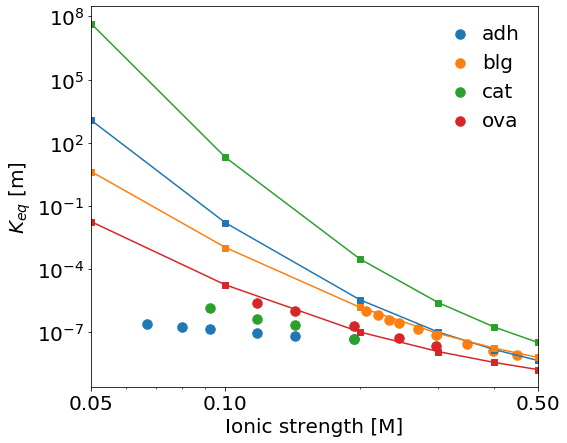

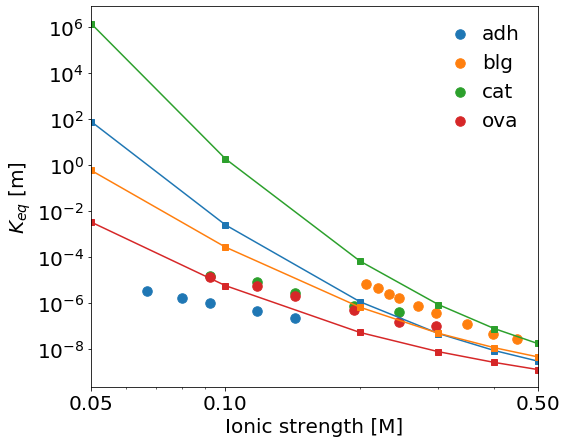

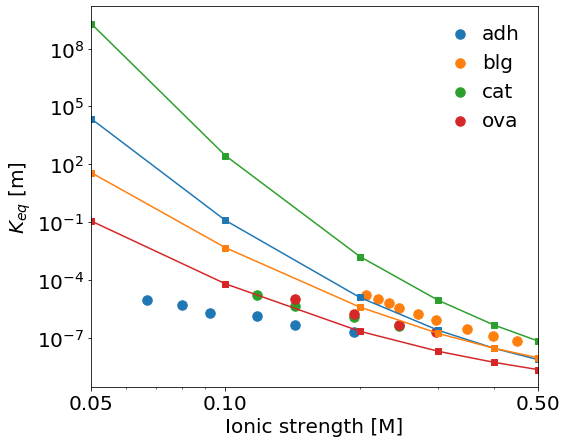

In [16]:
integrand_dir  = 'ns_bim_spherical/results_potential_lin_to_non_map/integrand_results/'

resin_list     = ['caq', 'phq', 'pxq']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results_potential_lin_to_non_map/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

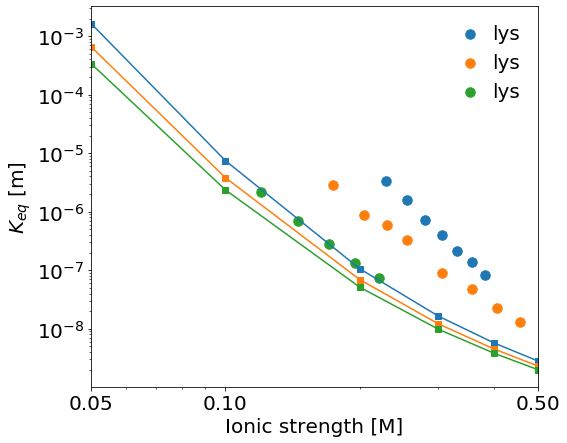

In [17]:
integrand_dir  = 'ns_bim_spherical/results_potential_lin_to_non_map/integrand_results/'

resin_list     = ['sep']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] != 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] != 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results_potential_lin_to_non_map/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

## Calculations with constant potential boundary condition, mapping linear to nonlinear surface potentials, setting histidine charges to +1

In [10]:
surf_dens_seph = 3.413e-6 # [mol m-2]
surf_dens_caq  = 3.016e-6
surf_dens_phq  = 2.55e-6
surf_dens_pxq  = 3.72e-6

sigma_seph = -1.0 * surf_dens_seph * constants().F # [C m-2]
sigma_caq  = surf_dens_caq * constants().F
sigma_phq  = surf_dens_phq * constants().F
sigma_pxq  = surf_dens_pxq * constants().F

print(sigma_seph, sigma_caq, sigma_phq, sigma_pxq)

-0.329303305 0.29099876 0.24603675000000003 0.35892419999999997


In [11]:
ns_bim_dir      = 'ns_bim_programs/'
protein_folders = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7', 'lys_pH_5', 'lys_pH_7',
                   'lys_pH_9', 'ova_pH_7']

protein_masses_Da           = [149540, 36750, 233120, 14390, 14390, 14390, 43000]
protein_spec_vol_cm3_per_g  = [0.769, 0.75, 0.73, 0.702, 0.702, 0.702, 0.75]

protein_eq_vol_radii_nm = []
for ind, m in enumerate(protein_masses_Da):
    v = protein_spec_vol_cm3_per_g[ind]
    protein_eq_vol_radii_nm.append((0.75/np.pi*m*v/constants().Na)**(1/3)*1.0e7)

ion_str_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# print(protein_eq_vol_radii_nm)

In [12]:
# for ion_str in ion_str_list:
#     for ind, protein in enumerate(protein_folders): 
#         radius_new   = protein_eq_vol_radii_nm[ind]
#         prot_dir     = 'ns_bim_spherical/ns_bim_programs/' + protein + '/'
#         new_folder   = 'ns_bim_spherical/results_potential_map_and_his_pos_charge/ns_bim_data/' + protein + '_' +\
#                        str(int(ion_str*1.0e3)) + '/'

#         meta_run_ns_bim_his_pos_charge(prot_dir, radius_new, ion_str, new_folder)

Successfully created the directory ns_bim_spherical/results_potential_map_and_his_pos_charge/ns_bim_data/adh_pH_7_50/
Successfully created the directory ns_bim_spherical/results_potential_map_and_his_pos_charge/ns_bim_data/blg_pH_7_50/
Successfully created the directory ns_bim_spherical/results_potential_map_and_his_pos_charge/ns_bim_data/cat_pH_7_50/
Successfully created the directory ns_bim_spherical/results_potential_map_and_his_pos_charge/ns_bim_data/lys_pH_5_50/
Successfully created the directory ns_bim_spherical/results_potential_map_and_his_pos_charge/ns_bim_data/lys_pH_7_50/
Successfully created the directory ns_bim_spherical/results_potential_map_and_his_pos_charge/ns_bim_data/lys_pH_9_50/
Successfully created the directory ns_bim_spherical/results_potential_map_and_his_pos_charge/ns_bim_data/ova_pH_7_50/
Successfully created the directory ns_bim_spherical/results_potential_map_and_his_pos_charge/ns_bim_data/adh_pH_7_100/
Successfully created the directory ns_bim_spherical/res

In [13]:
nsbim_data_dir = 'ns_bim_spherical/results_potential_map_and_his_pos_charge/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500',
 'lys_pH_5_100',
 'lys_pH_5_200',
 'lys_pH_5_300',
 'lys_pH_5_400',
 'lys_pH_5_50',
 'lys_pH_5_500',
 'lys_pH_7_100',
 'lys_pH_7_200',
 'lys_pH_7_300',
 'lys_pH_7_400',
 'lys_pH_7_50',
 'lys_pH_7_500',
 'lys_pH_9_100',
 'lys_pH_9_200',
 'lys_pH_9_300',
 'lys_pH_9_400',
 'lys_pH_9_50',
 'lys_pH_9_500',
 'ova_pH_7_100',
 'ova_pH_7_200',
 'ova_pH_7_300',
 'ova_pH_7_400',
 'ova_pH_7_50',
 'ova_pH_7_500']

In [14]:
elements_dict, node_dict, charge_dict = get_elem_and_node_dicts(nsbim_data_dir, protein_folders)
elements_dict = fill_elem_dict(elements_dict, node_dict, protein_folders)

In [17]:
integrand_dir  = 'ns_bim_spherical/results_potential_map_and_his_pos_charge/integrand_results/'
energy_dir     = 'ns_bim_spherical/results_potential_map_and_his_pos_charge/energy_results/'

resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] == 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)
            elements_df['potential_V'] =\
            map_pot_lin_to_nonlin(elements_df['potential_V'], sol)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
            new_energy_df.to_csv(energy_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


2.87
Completed caq_adh_pH_7_100.csv 

3.06
Completed caq_adh_pH_7_200.csv 

3.13
Completed caq_adh_pH_7_300.csv 

3.17
Completed caq_adh_pH_7_400.csv 

3.19
Completed caq_adh_pH_7_50.csv 

3.17
Completed caq_adh_pH_7_500.csv 

3.08
Completed caq_blg_pH_7_100.csv 

3.09
Completed caq_blg_pH_7_200.csv 

3.08
Completed caq_blg_pH_7_300.csv 

3.09
Completed caq_blg_pH_7_400.csv 

3.08
Completed caq_blg_pH_7_50.csv 

3.08
Completed caq_blg_pH_7_500.csv 

3.09
Completed caq_cat_pH_7_100.csv 

3.08
Completed caq_cat_pH_7_200.csv 

3.11
Completed caq_cat_pH_7_300.csv 

3.09
Completed caq_cat_pH_7_400.csv 

3.11
Completed caq_cat_pH_7_50.csv 

3.08
Completed caq_cat_pH_7_500.csv 

3.08
Completed caq_ova_pH_7_100.csv 

3.07
Completed caq_ova_pH_7_200.csv 

3.08
Completed caq_ova_pH_7_300.csv 

3.08
Completed caq_ova_pH_7_400.csv 

3.09
Completed caq_ova_pH_7_50.csv 

3.09
Completed caq_ova_pH_7_500.csv 

3.07
Completed phq_adh_pH_7_100.csv 

3.08
Completed phq_adh_pH_7_200.csv 

3.08
Completed p

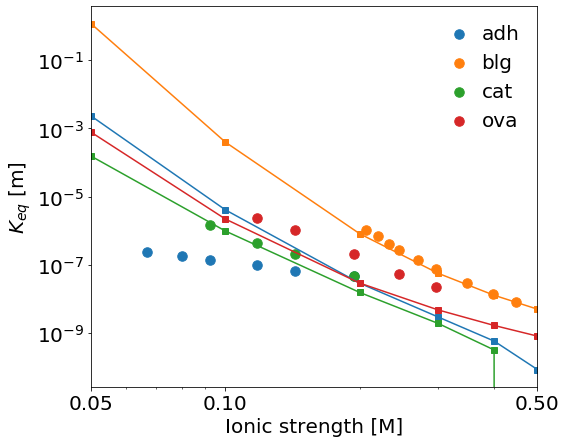

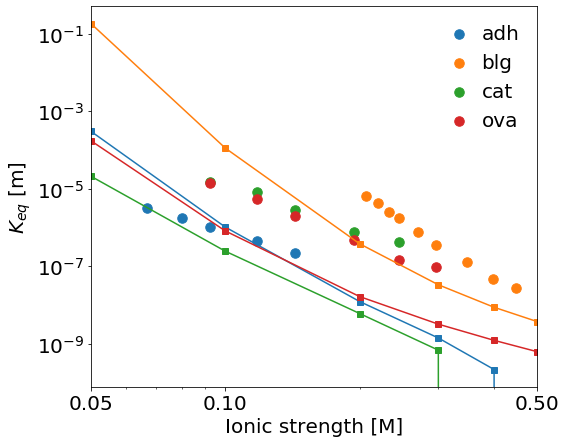

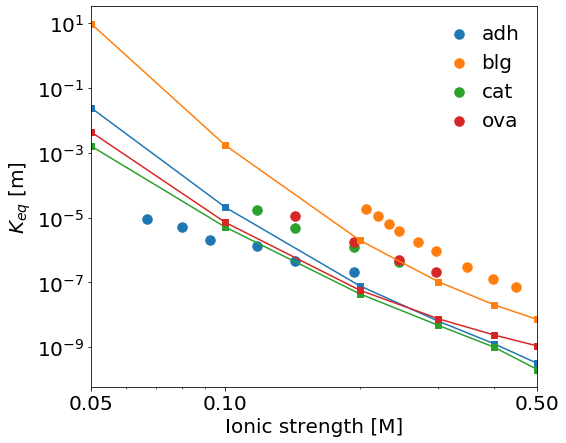

In [19]:
integrand_dir  = 'ns_bim_spherical/results_potential_map_and_his_pos_charge/integrand_results/'

resin_list     = ['caq', 'phq', 'pxq']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results_potential_map_and_his_pos_charge/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

In [20]:
integrand_dir  = 'ns_bim_spherical/results_potential_map_and_his_pos_charge/integrand_results/'
energy_dir     = 'ns_bim_spherical/results_potential_map_and_his_pos_charge/energy_results/'

resin_list = ['sep']

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] != 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)
            elements_df['potential_V'] =\
            map_pot_lin_to_nonlin(elements_df['potential_V'], sol)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
            new_energy_df.to_csv(energy_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


2.97
Completed sep_lys_pH_5_100.csv 

3.07
Completed sep_lys_pH_5_200.csv 

3.06
Completed sep_lys_pH_5_300.csv 

3.07
Completed sep_lys_pH_5_400.csv 

3.08
Completed sep_lys_pH_5_50.csv 

3.09
Completed sep_lys_pH_5_500.csv 

3.10
Completed sep_lys_pH_7_100.csv 

3.13
Completed sep_lys_pH_7_200.csv 

3.08
Completed sep_lys_pH_7_300.csv 

3.08
Completed sep_lys_pH_7_400.csv 

3.09
Completed sep_lys_pH_7_50.csv 

3.10
Completed sep_lys_pH_7_500.csv 

3.08
Completed sep_lys_pH_9_100.csv 

3.10
Completed sep_lys_pH_9_200.csv 

3.14
Completed sep_lys_pH_9_300.csv 

3.08
Completed sep_lys_pH_9_400.csv 

3.11
Completed sep_lys_pH_9_50.csv 

3.12
Completed sep_lys_pH_9_500.csv 



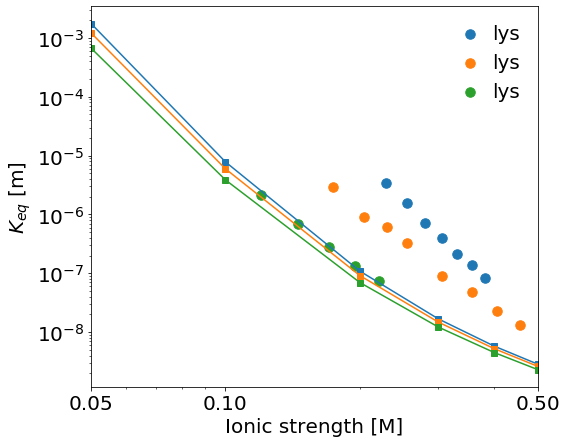

In [21]:
integrand_dir  = 'ns_bim_spherical/results_potential_map_and_his_pos_charge/integrand_results/'

resin_list     = ['sep']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] != 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] != 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results_potential_map_and_his_pos_charge/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

## q_HIS = +1, constant potential BC, but no potential mapping (i.e. directly using the surface potentials from NS-BIM)

In [22]:
nsbim_data_dir = 'ns_bim_spherical/results_potential_map_and_his_pos_charge/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500',
 'lys_pH_5_100',
 'lys_pH_5_200',
 'lys_pH_5_300',
 'lys_pH_5_400',
 'lys_pH_5_50',
 'lys_pH_5_500',
 'lys_pH_7_100',
 'lys_pH_7_200',
 'lys_pH_7_300',
 'lys_pH_7_400',
 'lys_pH_7_50',
 'lys_pH_7_500',
 'lys_pH_9_100',
 'lys_pH_9_200',
 'lys_pH_9_300',
 'lys_pH_9_400',
 'lys_pH_9_50',
 'lys_pH_9_500',
 'ova_pH_7_100',
 'ova_pH_7_200',
 'ova_pH_7_300',
 'ova_pH_7_400',
 'ova_pH_7_50',
 'ova_pH_7_500']

In [23]:
elements_dict, node_dict, charge_dict = get_elem_and_node_dicts(nsbim_data_dir, protein_folders)
elements_dict = fill_elem_dict(elements_dict, node_dict, protein_folders)

In [24]:
integrand_dir  = 'ns_bim_spherical/results_his_pos_charge/integrand_results/'
energy_dir     = 'ns_bim_spherical/results_his_pos_charge/energy_results/'

resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] == 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
            new_energy_df.to_csv(energy_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


2.91
Completed caq_adh_pH_7_100.csv 

3.05
Completed caq_adh_pH_7_200.csv 

3.09
Completed caq_adh_pH_7_300.csv 

3.09
Completed caq_adh_pH_7_400.csv 

3.10
Completed caq_adh_pH_7_50.csv 

3.09
Completed caq_adh_pH_7_500.csv 

3.05
Completed caq_blg_pH_7_100.csv 

3.07
Completed caq_blg_pH_7_200.csv 

3.10
Completed caq_blg_pH_7_300.csv 

3.12
Completed caq_blg_pH_7_400.csv 

3.08
Completed caq_blg_pH_7_50.csv 

3.08
Completed caq_blg_pH_7_500.csv 

3.13
Completed caq_cat_pH_7_100.csv 

3.10
Completed caq_cat_pH_7_200.csv 

3.10
Completed caq_cat_pH_7_300.csv 

3.10
Completed caq_cat_pH_7_400.csv 

3.10
Completed caq_cat_pH_7_50.csv 

3.09
Completed caq_cat_pH_7_500.csv 

3.07
Completed caq_ova_pH_7_100.csv 

3.09
Completed caq_ova_pH_7_200.csv 

3.09
Completed caq_ova_pH_7_300.csv 

3.09
Completed caq_ova_pH_7_400.csv 

3.08
Completed caq_ova_pH_7_50.csv 

3.09
Completed caq_ova_pH_7_500.csv 

3.12
Completed phq_adh_pH_7_100.csv 

3.09
Completed phq_adh_pH_7_200.csv 

3.08
Completed p

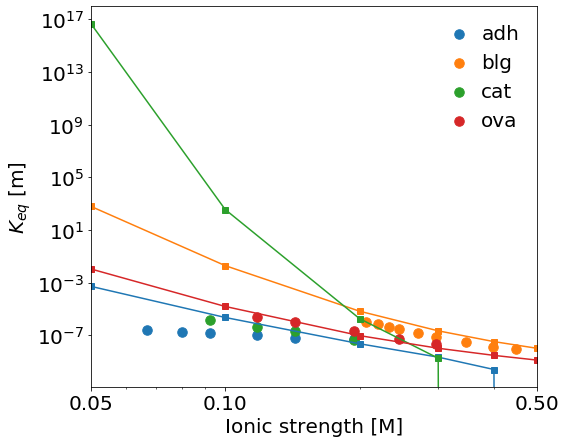

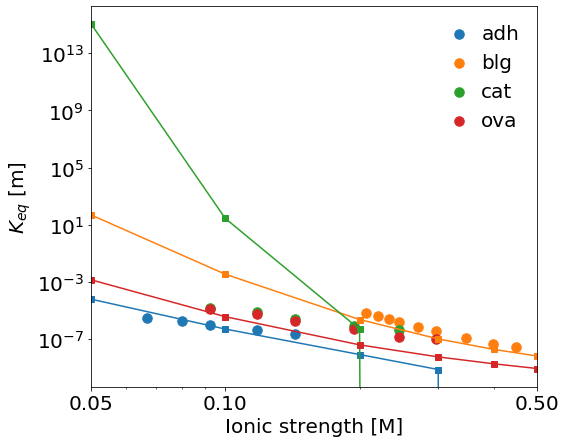

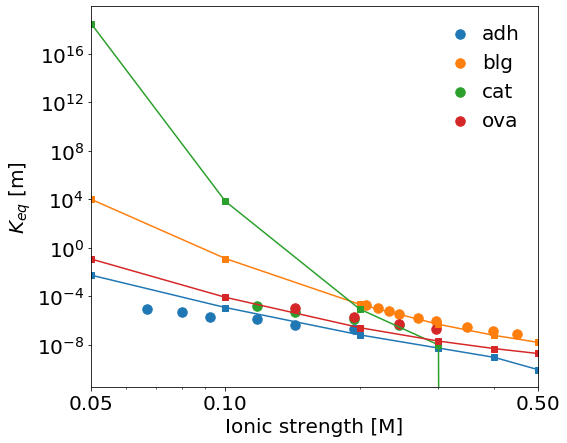

In [25]:
integrand_dir  = 'ns_bim_spherical/results_his_pos_charge/integrand_results/'

resin_list     = ['caq', 'phq', 'pxq']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results_his_pos_charge/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

In [26]:
integrand_dir  = 'ns_bim_spherical/results_his_pos_charge/integrand_results/'
energy_dir     = 'ns_bim_spherical/results_his_pos_charge/energy_results/'

resin_list = ['sep']

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] != 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
            new_energy_df.to_csv(energy_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


3.11
Completed sep_lys_pH_5_100.csv 

3.11
Completed sep_lys_pH_5_200.csv 

3.13
Completed sep_lys_pH_5_300.csv 

3.12
Completed sep_lys_pH_5_400.csv 

3.11
Completed sep_lys_pH_5_50.csv 

3.12
Completed sep_lys_pH_5_500.csv 

3.11
Completed sep_lys_pH_7_100.csv 

3.13
Completed sep_lys_pH_7_200.csv 

3.13
Completed sep_lys_pH_7_300.csv 

3.12
Completed sep_lys_pH_7_400.csv 

3.13
Completed sep_lys_pH_7_50.csv 

3.12
Completed sep_lys_pH_7_500.csv 

3.12
Completed sep_lys_pH_9_100.csv 

3.12
Completed sep_lys_pH_9_200.csv 

3.14
Completed sep_lys_pH_9_300.csv 

3.12
Completed sep_lys_pH_9_400.csv 

3.12
Completed sep_lys_pH_9_50.csv 

3.13
Completed sep_lys_pH_9_500.csv 



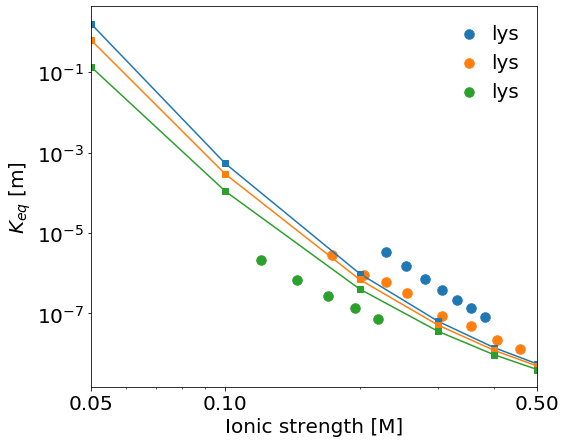

In [27]:
integrand_dir  = 'ns_bim_spherical/results_his_pos_charge/integrand_results/'

resin_list     = ['sep']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] != 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] != 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results_his_pos_charge/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

## q_HIS = +0.5, constant potential BC, but no potential mapping (i.e. directly using the surface potentials from NS-BIM)

In [3]:
surf_dens_seph = 3.413e-6 # [mol m-2]
surf_dens_caq  = 3.016e-6
surf_dens_phq  = 2.55e-6
surf_dens_pxq  = 3.72e-6

sigma_seph = -1.0 * surf_dens_seph * constants().F # [C m-2]
sigma_caq  = surf_dens_caq * constants().F
sigma_phq  = surf_dens_phq * constants().F
sigma_pxq  = surf_dens_pxq * constants().F

print(sigma_seph, sigma_caq, sigma_phq, sigma_pxq)

-0.329303305 0.29099876 0.24603675000000003 0.35892419999999997


In [4]:
ns_bim_dir      = 'ns_bim_programs/'
protein_folders = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7', 'lys_pH_5', 'lys_pH_7',
                   'lys_pH_9', 'ova_pH_7']

protein_masses_Da           = [149540, 36750, 233120, 14390, 14390, 14390, 43000]
protein_spec_vol_cm3_per_g  = [0.769, 0.75, 0.73, 0.702, 0.702, 0.702, 0.75]

protein_eq_vol_radii_nm = []
for ind, m in enumerate(protein_masses_Da):
    v = protein_spec_vol_cm3_per_g[ind]
    protein_eq_vol_radii_nm.append((0.75/np.pi*m*v/constants().Na)**(1/3)*1.0e7)

ion_str_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# print(protein_eq_vol_radii_nm)

In [6]:
# for ion_str in ion_str_list:
#     for ind, protein in enumerate(protein_folders): 
#         radius_new   = protein_eq_vol_radii_nm[ind]
#         prot_dir     = 'ns_bim_spherical/ns_bim_programs/' + protein + '/'
#         new_folder   = 'ns_bim_spherical/results_his_charge_0pt5/ns_bim_data/' + protein + '_' +\
#                        str(int(ion_str*1.0e3)) + '/'

#         meta_run_ns_bim_his_pos_charge(prot_dir, radius_new, ion_str, new_folder)

In [5]:
nsbim_data_dir = 'ns_bim_spherical/results_his_charge_0pt5/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500',
 'lys_pH_5_100',
 'lys_pH_5_200',
 'lys_pH_5_300',
 'lys_pH_5_400',
 'lys_pH_5_50',
 'lys_pH_5_500',
 'lys_pH_7_100',
 'lys_pH_7_200',
 'lys_pH_7_300',
 'lys_pH_7_400',
 'lys_pH_7_50',
 'lys_pH_7_500',
 'lys_pH_9_100',
 'lys_pH_9_200',
 'lys_pH_9_300',
 'lys_pH_9_400',
 'lys_pH_9_50',
 'lys_pH_9_500',
 'ova_pH_7_100',
 'ova_pH_7_200',
 'ova_pH_7_300',
 'ova_pH_7_400',
 'ova_pH_7_50',
 'ova_pH_7_500']

In [8]:
elements_dict, node_dict, charge_dict = get_elem_and_node_dicts(nsbim_data_dir, protein_folders)
elements_dict = fill_elem_dict(elements_dict, node_dict, protein_folders)

In [35]:
integrand_dir  = 'ns_bim_spherical/results_his_charge_0pt5/integrand_results/'

resin_list = ['caq', 'phq', 'pxq']

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] == 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
#             new_energy_df.to_csv(energy_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


2.89
Completed caq_adh_pH_7_100.csv 

3.02
Completed caq_adh_pH_7_200.csv 

3.05
Completed caq_adh_pH_7_300.csv 

3.11
Completed caq_adh_pH_7_400.csv 

3.11
Completed caq_adh_pH_7_50.csv 

3.17
Completed caq_adh_pH_7_500.csv 

3.07
Completed caq_blg_pH_7_100.csv 

3.09
Completed caq_blg_pH_7_200.csv 

3.13
Completed caq_blg_pH_7_300.csv 

3.17
Completed caq_blg_pH_7_400.csv 

3.15
Completed caq_blg_pH_7_50.csv 

3.09
Completed caq_blg_pH_7_500.csv 

3.10
Completed caq_cat_pH_7_100.csv 

3.11
Completed caq_cat_pH_7_200.csv 

3.10
Completed caq_cat_pH_7_300.csv 

3.14
Completed caq_cat_pH_7_400.csv 

3.09
Completed caq_cat_pH_7_50.csv 

3.13
Completed caq_cat_pH_7_500.csv 

3.14
Completed caq_ova_pH_7_100.csv 

3.10
Completed caq_ova_pH_7_200.csv 

3.16
Completed caq_ova_pH_7_300.csv 

3.08
Completed caq_ova_pH_7_400.csv 

3.11
Completed caq_ova_pH_7_50.csv 

3.08
Completed caq_ova_pH_7_500.csv 

3.11
Completed phq_adh_pH_7_100.csv 

3.10
Completed phq_adh_pH_7_200.csv 

3.16
Completed p

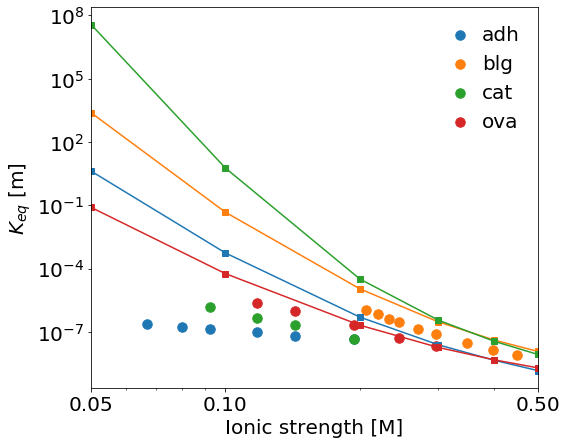

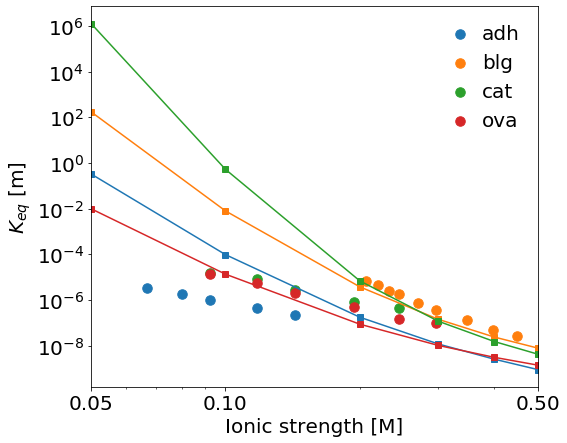

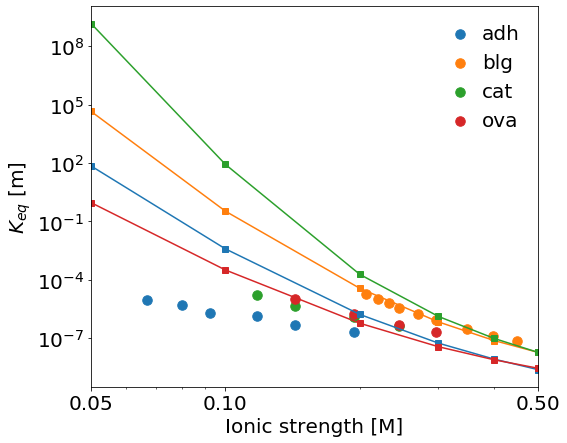

In [36]:
integrand_dir  = 'ns_bim_spherical/results_his_charge_0pt5/integrand_results/'

resin_list     = ['caq', 'phq', 'pxq']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results_his_charge_0pt5/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

In [9]:
integrand_dir  = 'ns_bim_spherical/results_his_charge_0pt5/integrand_results/'

resin_list = ['sep']

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] != 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count()-4)
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
#             new_energy_df.to_csv(energy_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


4.60
Completed sep_lys_pH_5_100.csv 

4.64
Completed sep_lys_pH_5_200.csv 

4.70
Completed sep_lys_pH_5_300.csv 

4.72
Completed sep_lys_pH_5_400.csv 

4.71
Completed sep_lys_pH_5_50.csv 

4.71
Completed sep_lys_pH_5_500.csv 

4.72
Completed sep_lys_pH_7_100.csv 

4.71
Completed sep_lys_pH_7_200.csv 

4.72
Completed sep_lys_pH_7_300.csv 

4.72
Completed sep_lys_pH_7_400.csv 

4.70
Completed sep_lys_pH_7_50.csv 

4.71
Completed sep_lys_pH_7_500.csv 

4.69
Completed sep_lys_pH_9_100.csv 

4.72
Completed sep_lys_pH_9_200.csv 

4.72
Completed sep_lys_pH_9_300.csv 

4.70
Completed sep_lys_pH_9_400.csv 

4.69
Completed sep_lys_pH_9_50.csv 

4.71
Completed sep_lys_pH_9_500.csv 



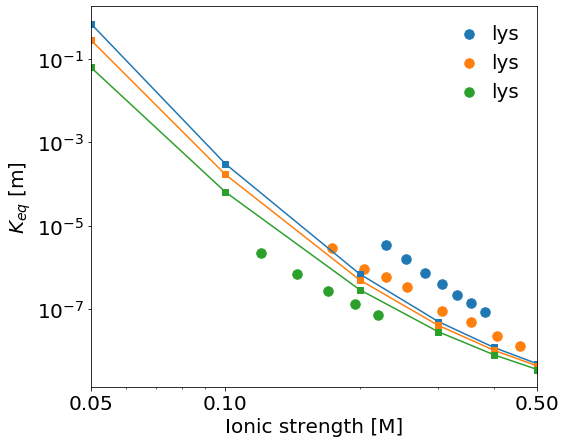

In [7]:
integrand_dir  = 'ns_bim_spherical/results_his_charge_0pt5/integrand_results/'

resin_list     = ['sep']

z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] != 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] != 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results_his_charge_0pt5/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

## Charge data from .pqr files, no potential mapping (i.e. directly using the surface potentials from NS-BIM)

In [22]:
surf_dens_seph = 3.413e-6 # [mol m-2]
surf_dens_caq  = 3.016e-6
surf_dens_phq  = 2.55e-6
surf_dens_pxq  = 3.72e-6

sigma_seph = -1.0 * surf_dens_seph * constants().F # [C m-2]
sigma_caq  = surf_dens_caq * constants().F
sigma_phq  = surf_dens_phq * constants().F
sigma_pxq  = surf_dens_pxq * constants().F

print(sigma_seph, sigma_caq, sigma_phq, sigma_pxq)

-0.329303305 0.29099876 0.24603675000000003 0.35892419999999997


In [23]:
ns_bim_dir      = 'ns_bim_programs/'
protein_folders = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7', 'lys_pH_5', 'lys_pH_7',
                   'lys_pH_9', 'ova_pH_7']

protein_masses_Da           = [149540, 36750, 233120, 14390, 14390, 14390, 43000]
protein_spec_vol_cm3_per_g  = [0.769, 0.75, 0.73, 0.702, 0.702, 0.702, 0.75]

protein_eq_vol_radii_nm = []
for ind, m in enumerate(protein_masses_Da):
    v = protein_spec_vol_cm3_per_g[ind]
    protein_eq_vol_radii_nm.append((0.75/np.pi*m*v/constants().Na)**(1/3)*1.0e7)

ion_str_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

print(protein_eq_vol_radii_nm)

[3.572329022173039, 2.2190295321197273, 4.070905409619967, 1.5880207828750268, 1.5880207828750268, 1.5880207828750268, 2.3382994068696057]


In [21]:
for ion_str in ion_str_list:
    for ind, protein in enumerate(protein_folders): 
        radius_new   = protein_eq_vol_radii_nm[ind]
        prot_dir     = 'ns_bim_spherical/ns_bim_programs/' + protein + '/'
        new_folder   = 'ns_bim_spherical/results_pqr_charges/ns_bim_data/' + protein + '_' +\
                       str(int(ion_str*1.0e3)) + '/'
#         new_folder   = 'ns_bim_spherical/results_pqr_partial_charges/ns_bim_data/' + protein + '_' +\
#                        str(int(ion_str*1.0e3)) + '/'

        meta_run_ns_bim_pqr_charge(prot_dir, radius_new, ion_str, new_folder)
#         meta_run_ns_bim_pqr_partial_charge(prot_dir, radius_new, ion_str, new_folder)

Creation of the directory ns_bim_spherical/results_pqr_charges/ns_bim_data/adh_pH_7_50/ failed
Creation of the directory ns_bim_spherical/results_pqr_charges/ns_bim_data/adh_pH_7_100/ failed
Creation of the directory ns_bim_spherical/results_pqr_charges/ns_bim_data/adh_pH_7_200/ failed
Creation of the directory ns_bim_spherical/results_pqr_charges/ns_bim_data/adh_pH_7_300/ failed
Creation of the directory ns_bim_spherical/results_pqr_charges/ns_bim_data/adh_pH_7_400/ failed
Creation of the directory ns_bim_spherical/results_pqr_charges/ns_bim_data/adh_pH_7_500/ failed


In [24]:
nsbim_data_dir = 'ns_bim_spherical/results_pqr_charges/ns_bim_data/'
# nsbim_data_dir = 'ns_bim_spherical/results_pqr_partial_charges/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500',
 'lys_pH_5_100',
 'lys_pH_5_200',
 'lys_pH_5_300',
 'lys_pH_5_400',
 'lys_pH_5_50',
 'lys_pH_5_500',
 'lys_pH_7_100',
 'lys_pH_7_200',
 'lys_pH_7_300',
 'lys_pH_7_400',
 'lys_pH_7_50',
 'lys_pH_7_500',
 'lys_pH_9_100',
 'lys_pH_9_200',
 'lys_pH_9_300',
 'lys_pH_9_400',
 'lys_pH_9_50',
 'lys_pH_9_500',
 'ova_pH_7_100',
 'ova_pH_7_200',
 'ova_pH_7_300',
 'ova_pH_7_400',
 'ova_pH_7_50',
 'ova_pH_7_500']

In [23]:
elements_dict, node_dict, charge_dict = get_elem_and_node_dicts(nsbim_data_dir, protein_folders)
elements_dict = fill_elem_dict(elements_dict, node_dict, protein_folders)

In [33]:
integrand_dir  = 'ns_bim_spherical/results_pqr_charges/integrand_results/'
resin_list = ['caq', 'phq', 'pxq']

In [24]:
for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] == 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
            
            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


4.48
Completed caq_adh_pH_7_100.csv 

4.63
Completed caq_adh_pH_7_200.csv 

4.67
Completed caq_adh_pH_7_300.csv 

4.66
Completed caq_adh_pH_7_400.csv 

4.64
Completed caq_adh_pH_7_50.csv 

4.64
Completed caq_adh_pH_7_500.csv 

4.68
Completed phq_adh_pH_7_100.csv 

4.66
Completed phq_adh_pH_7_200.csv 

4.66
Completed phq_adh_pH_7_300.csv 

4.67
Completed phq_adh_pH_7_400.csv 

4.65
Completed phq_adh_pH_7_50.csv 

4.65
Completed phq_adh_pH_7_500.csv 

4.65
Completed pxq_adh_pH_7_100.csv 

4.65
Completed pxq_adh_pH_7_200.csv 

4.63
Completed pxq_adh_pH_7_300.csv 

4.66
Completed pxq_adh_pH_7_400.csv 

4.65
Completed pxq_adh_pH_7_50.csv 

4.64
Completed pxq_adh_pH_7_500.csv 



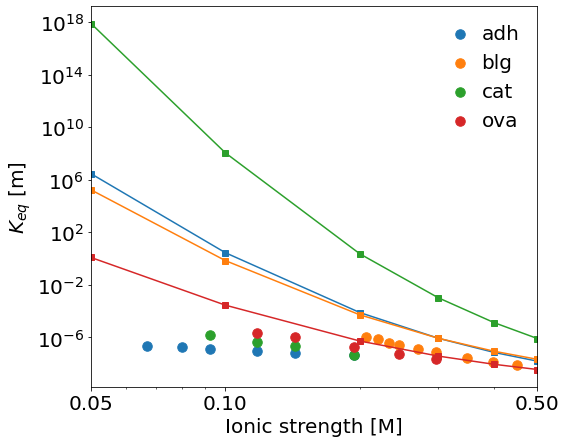

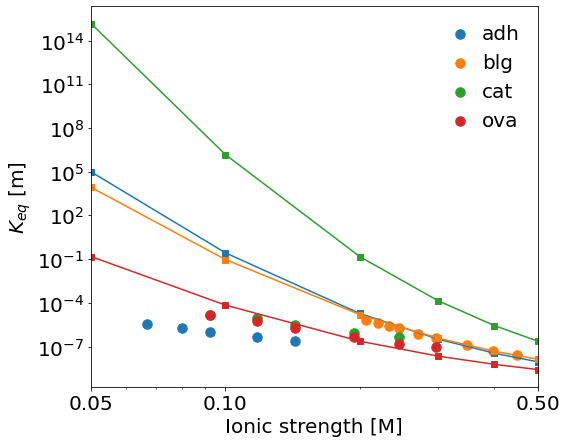

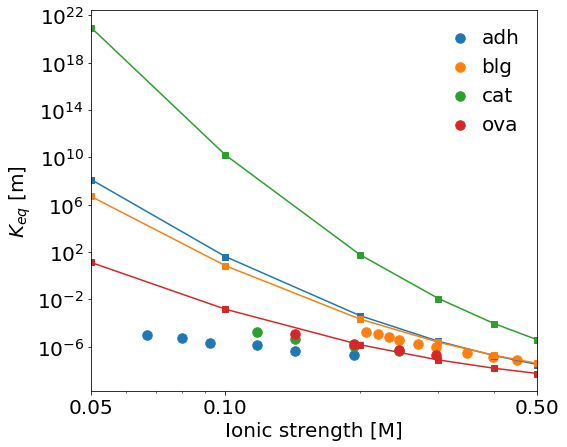

In [34]:
resin_list = ['caq', 'phq', 'pxq']
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq
    
    #ADDITION TO SAVE KEQ results
    list_results = []
    for rkey in res:
        list_results.append([rkey[:3], get_ion_str_from_protein_name(rkey), res[rkey]])
    df = pd.DataFrame(list_results, columns=['protein', 'IS(M)', 'Keq'])
    df.to_csv('ns_bim_spherical/results_pqr_charges/Keq_predictions_' + resin + '.csv',
              index=False)
    
    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

#     fig.savefig('ns_bim_spherical/results_pqr_charges/images/' + resin + '_' +\
#                 str(int(round(z0*1.0e12))) + '_pm_z0.png', 
#                 bbox_inches='tight', dpi = 300)

In [28]:
resin_list = ['sep']


In [10]:

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] != 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


4.63
Completed sep_lys_pH_5_100.csv 

4.66
Completed sep_lys_pH_5_200.csv 

4.63
Completed sep_lys_pH_5_300.csv 

4.64
Completed sep_lys_pH_5_400.csv 

4.66
Completed sep_lys_pH_5_50.csv 

4.68
Completed sep_lys_pH_5_500.csv 

4.67
Completed sep_lys_pH_7_100.csv 

4.65
Completed sep_lys_pH_7_200.csv 

4.65
Completed sep_lys_pH_7_300.csv 

4.65
Completed sep_lys_pH_7_400.csv 

4.66
Completed sep_lys_pH_7_50.csv 

4.65
Completed sep_lys_pH_7_500.csv 

4.67
Completed sep_lys_pH_9_100.csv 

4.66
Completed sep_lys_pH_9_200.csv 

4.70
Completed sep_lys_pH_9_300.csv 

4.68
Completed sep_lys_pH_9_400.csv 

4.67
Completed sep_lys_pH_9_50.csv 

4.68
Completed sep_lys_pH_9_500.csv 



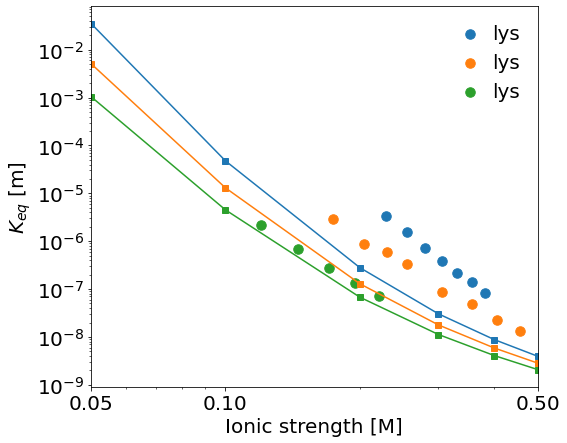

In [32]:
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] != 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    #ADDITION TO SAVE KEQ results
    list_results = []
    for rkey in res:
        list_results.append([rkey[:3], get_ion_str_from_protein_name(rkey), res[rkey]])
    df = pd.DataFrame(list_results, columns=['protein', 'IS(M)', 'Keq'])
    df.to_csv('ns_bim_spherical/results_pqr_charges/Keq_predictions_' + resin + '.csv',
              index=False)
    
    for key in species_pH:
        if key[:3] != 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('ns_bim_spherical/results_pqr_charges/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

In [ ]:
########

## Surface charges

In [5]:
surf_dens_seph = 3.413e-6 # [mol m-2]
surf_dens_caq  = 3.016e-6
surf_dens_phq  = 2.55e-6
surf_dens_pxq  = 3.72e-6

sigma_seph = -1.0 * surf_dens_seph * constants().F # [C m-2]
sigma_caq  = surf_dens_caq * constants().F
sigma_phq  = surf_dens_phq * constants().F
sigma_pxq  = surf_dens_pxq * constants().F

print(sigma_seph, sigma_caq, sigma_phq, sigma_pxq)

-0.329303305 0.29099876 0.24603675000000003 0.35892419999999997


In [7]:
ns_bim_dir      = 'ns_bim_programs/'
protein_folders = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7', 'lys_pH_5', 'lys_pH_7',
                   'lys_pH_9', 'ova_pH_7']

protein_masses_Da           = [149540, 36750, 233120, 14390, 14390, 14390, 43000]
protein_spec_vol_cm3_per_g  = [0.769, 0.75, 0.73, 0.702, 0.702, 0.702, 0.75]

protein_eq_vol_radii_nm = []
for ind, m in enumerate(protein_masses_Da):
    v = protein_spec_vol_cm3_per_g[ind]
    protein_eq_vol_radii_nm.append((0.75/np.pi*m*v/constants().Na)**(1/3)*1.0e7)

ion_str_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

print(protein_eq_vol_radii_nm)

[3.572329022173039, 2.2190295321197273, 4.070905409619967, 1.5880207828750268, 1.5880207828750268, 1.5880207828750268, 2.3382994068696057]


In [8]:
for ion_str in ion_str_list:
    for ind, protein in enumerate(protein_folders): 
        radius_new   = protein_eq_vol_radii_nm[ind]
        prot_dir     = 'ns_bim_spherical/ns_bim_programs/' + protein + '/'
        new_folder   = 'ns_bim_spherical/results_pqr_charges_surface/ns_bim_data/' + protein + '_' +\
                       str(int(ion_str*1.0e3)) + '/'

        meta_run_ns_bim_pqr_charge_surface(prot_dir, radius_new, ion_str, new_folder)

Successfully created the directory ns_bim_spherical/results_pqr_charges_surface/ns_bim_data/adh_pH_7_50/
Successfully created the directory ns_bim_spherical/results_pqr_charges_surface/ns_bim_data/blg_pH_7_50/
Successfully created the directory ns_bim_spherical/results_pqr_charges_surface/ns_bim_data/cat_pH_7_50/
Successfully created the directory ns_bim_spherical/results_pqr_charges_surface/ns_bim_data/lys_pH_5_50/
Successfully created the directory ns_bim_spherical/results_pqr_charges_surface/ns_bim_data/lys_pH_7_50/
Successfully created the directory ns_bim_spherical/results_pqr_charges_surface/ns_bim_data/lys_pH_9_50/
Successfully created the directory ns_bim_spherical/results_pqr_charges_surface/ns_bim_data/ova_pH_7_50/
Successfully created the directory ns_bim_spherical/results_pqr_charges_surface/ns_bim_data/adh_pH_7_100/
Successfully created the directory ns_bim_spherical/results_pqr_charges_surface/ns_bim_data/blg_pH_7_100/
Successfully created the directory ns_bim_spherical/r

In [9]:
nsbim_data_dir = 'ns_bim_spherical/results_pqr_charges_surface/ns_bim_data/'
# nsbim_data_dir = 'ns_bim_spherical/results_pqr_partial_charges/ns_bim_data/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500',
 'lys_pH_5_100',
 'lys_pH_5_200',
 'lys_pH_5_300',
 'lys_pH_5_400',
 'lys_pH_5_50',
 'lys_pH_5_500',
 'lys_pH_7_100',
 'lys_pH_7_200',
 'lys_pH_7_300',
 'lys_pH_7_400',
 'lys_pH_7_50',
 'lys_pH_7_500',
 'lys_pH_9_100',
 'lys_pH_9_200',
 'lys_pH_9_300',
 'lys_pH_9_400',
 'lys_pH_9_50',
 'lys_pH_9_500',
 'ova_pH_7_100',
 'ova_pH_7_200',
 'ova_pH_7_300',
 'ova_pH_7_400',
 'ova_pH_7_50',
 'ova_pH_7_500']

In [10]:
elements_dict, node_dict, charge_dict = get_elem_and_node_dicts(nsbim_data_dir, protein_folders)
elements_dict = fill_elem_dict(elements_dict, node_dict, protein_folders)

In [11]:
integrand_dir  = 'ns_bim_spherical/results_pqr_charges_surface/integrand_results/'
resin_list = ['caq', 'phq', 'pxq']

In [13]:
for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] == 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)
            
            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


1.53
Completed caq_adh_pH_7_100.csv 

1.59
Completed caq_adh_pH_7_200.csv 

1.64
Completed caq_adh_pH_7_300.csv 

1.68
Completed caq_adh_pH_7_400.csv 

1.69
Completed caq_adh_pH_7_50.csv 

1.71
Completed caq_adh_pH_7_500.csv 

1.70
Completed caq_blg_pH_7_100.csv 

1.71
Completed caq_blg_pH_7_200.csv 

1.71
Completed caq_blg_pH_7_300.csv 

1.74
Completed caq_blg_pH_7_400.csv 

1.71
Completed caq_blg_pH_7_50.csv 

1.72
Completed caq_blg_pH_7_500.csv 

1.73
Completed caq_cat_pH_7_100.csv 

1.73
Completed caq_cat_pH_7_200.csv 

1.73
Completed caq_cat_pH_7_300.csv 

1.73
Completed caq_cat_pH_7_400.csv 

1.72
Completed caq_cat_pH_7_50.csv 

1.73
Completed caq_cat_pH_7_500.csv 

1.72
Completed caq_ova_pH_7_100.csv 

1.73
Completed caq_ova_pH_7_200.csv 

1.73
Completed caq_ova_pH_7_300.csv 

1.73
Completed caq_ova_pH_7_400.csv 

1.73
Completed caq_ova_pH_7_50.csv 

1.74
Completed caq_ova_pH_7_500.csv 

1.76
Completed phq_adh_pH_7_100.csv 

1.75
Completed phq_adh_pH_7_200.csv 

1.74
Completed p

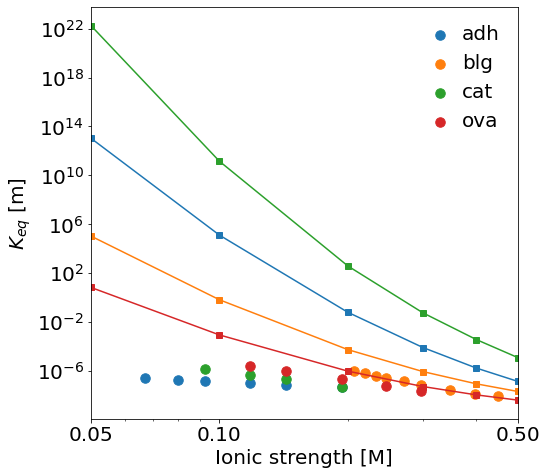

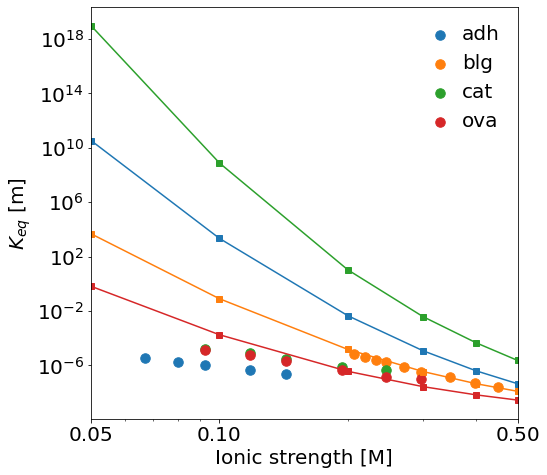

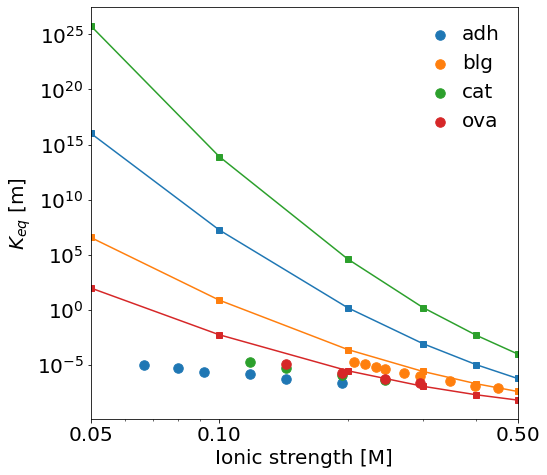

In [19]:
resin_list = ['caq', 'phq', 'pxq']
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq
    
    #ADDITION TO SAVE KEQ results
    list_results = []
    for rkey in res:
        list_results.append([rkey[:3], get_ion_str_from_protein_name(rkey), res[rkey]])
    df = pd.DataFrame(list_results, columns=['protein', 'IS(M)', 'Keq'])
    df.to_csv('ns_bim_spherical/results_pqr_charges_surface/Keq_predictions_' + resin + '.csv',
              index=False)
    
    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)
    
    fig.patch.set_alpha(1.0)
    plt.tight_layout()
    fig.savefig('ns_bim_spherical/results_pqr_charges_surface/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

In [21]:
resin_list = ['sep']


In [17]:

for resin in resin_list:
    for protein in protein_folders:

        if protein[:3] != 'lys':
            pass
        else:
            start_time = time.time()
            
            elements_df = elements_dict[protein].copy()            
            ion_str     = get_ion_str_from_protein_name(protein)
            sol         = bulk_solution(ion_str)

            kap_h_min   = 0.1
            kap_h_mid   = 1.2
            kap_h_max   = 9.0
            z_min       = kap_h_min/sol.kappa # [m]
            z_mid       = kap_h_mid/sol.kappa
            z_max       = kap_h_max/sol.kappa
            zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                                 np.linspace(z_mid, z_max, 21)))

            energy_map_file = 'oc_energy_maps/' + resin + '_' +\
            str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
            energy_fun      = get_interp_fun(energy_map_file)

            args_list = [(i, elements_df, zs, energy_fun, sol) for i\
                         in elements_df.index]
            pool      = mp.Pool(processes = mp.cpu_count())
            results   = pool.map(get_integrand_list, args_list)
            pool.close()
            pool.join()

            indeces       = [res[0] for res in results]
            integrand_res = [res[1] for res in results]
            energy_res    = [res[2] for res in results]

            new_integrand_df = pd.DataFrame(integrand_res, index=indeces, columns=zs)
            new_energy_df    = pd.DataFrame(energy_res, index=indeces, columns=zs)

            file = resin + '_' + protein + '.csv'

            new_integrand_df.to_csv(integrand_dir + file)

            print_time((time.time() - start_time)/60.0)
            print('Completed ' + file + ' \n')


1.74
Completed sep_lys_pH_5_100.csv 

1.74
Completed sep_lys_pH_5_200.csv 

1.74
Completed sep_lys_pH_5_300.csv 

1.75
Completed sep_lys_pH_5_400.csv 

1.74
Completed sep_lys_pH_5_50.csv 

1.77
Completed sep_lys_pH_5_500.csv 

1.75
Completed sep_lys_pH_7_100.csv 

1.75
Completed sep_lys_pH_7_200.csv 

1.75
Completed sep_lys_pH_7_300.csv 

1.74
Completed sep_lys_pH_7_400.csv 

1.75
Completed sep_lys_pH_7_50.csv 

1.76
Completed sep_lys_pH_7_500.csv 

1.74
Completed sep_lys_pH_9_100.csv 

1.74
Completed sep_lys_pH_9_200.csv 

1.74
Completed sep_lys_pH_9_300.csv 

1.75
Completed sep_lys_pH_9_400.csv 

1.74
Completed sep_lys_pH_9_50.csv 

1.74
Completed sep_lys_pH_9_500.csv 



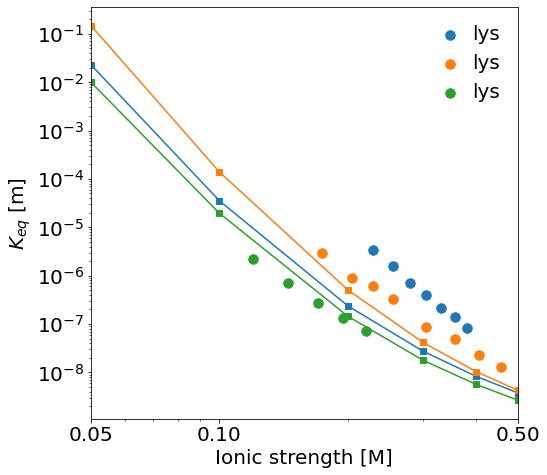

In [22]:
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    # # axs.set_ylim(7e-9, 1e-5)
#     ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] != 'lys':
            pass
        else:
            ion_str     = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    #ADDITION TO SAVE KEQ results
    list_results = []
    for rkey in res:
        list_results.append([rkey[:3], get_ion_str_from_protein_name(rkey), res[rkey]])
    df = pd.DataFrame(list_results, columns=['protein', 'IS(M)', 'Keq'])
    df.to_csv('ns_bim_spherical/results_pqr_charges_surface/Keq_predictions_' + resin + '.csv',
              index=False)
    
    for key in species_pH:
        if key[:3] != 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.patch.set_alpha(1.0)
    plt.tight_layout()
    fig.savefig('ns_bim_spherical/results_pqr_charges_surface/images/' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

# Monte Carlo assignment of charge locations

### Set up - always run

In [3]:
protein_masses_Da           = [149540, 36750, 233120, 14390, 14390, 14390, 43000]
protein_spec_vol_cm3_per_g  = [0.769, 0.75, 0.73, 0.702, 0.702, 0.702, 0.75]

protein_eq_vol_radii_nm = []
for ind, m in enumerate(protein_masses_Da):
    v = protein_spec_vol_cm3_per_g[ind]
    protein_eq_vol_radii_nm.append((0.75/np.pi*m*v/constants().Na)**(1/3)*1.0e7)

In [34]:
n_iterations = 50
ion_str_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

depth = 0.15
rad_lys = protein_eq_vol_radii_nm[-2]
rad_ova = protein_eq_vol_radii_nm[-1]
rad_lys_q = rad_lys - depth
rad_ova_q = rad_ova - depth

ns_bim_dir  = 'ns_bim_spherical/ns_bim_programs/'
pot_file    = 'rslt_protein_potential_variable_radius.csv'
charge_file = 'rslt_protein_charge_variable_radius.csv'

### Functions

Note:  these were exported to monte_carlo_functions.py after use; the following cells can/should be deleted after verifying the imports are correct.

In [4]:
# # Functions for random/MC assignment of charge location

# def get_rand_theta_phi():
#     theta = 2.0*np.pi*random.random()
#     phi   = np.arccos(1.0 - 2.0*random.random())
#     return (theta, phi)

# def get_x_y_z(radius):
#     (theta, phi) = get_rand_theta_phi()
#     x = radius*np.sin(phi)*np.cos(theta)
#     y = radius*np.sin(phi)*np.sin(theta)
#     z = radius*np.cos(phi)
#     return (x, y, z)

# def place_charges(df_charges, radius_q):
#     for i, cont in df_charges.iterrows():
#         (x, y, z) = get_x_y_z(radius_q)
#         df_charges.at[i, 'x_new_nm'] = x
#         df_charges.at[i, 'y_new_nm'] = y
#         df_charges.at[i, 'z_new_nm'] = z
#     return df_charges

In [5]:
# # Functions for using MC results in numerical Derjaguin model

# def get_ion_str_from_mc_file_name(name, out_type='str'):
#     ind_1 = name.rfind('_') + 1
#     ind_2 = name.rfind('.')
#     if out_type == 'str':
#         return name[ind_1:ind_2]
#     elif out_type == 'float':
#         return int(name[ind_1:ind_2])/1000
#     else:
#         print('Invalid output type.')
#         return

# def get_mc_result_files(mc_res_dir):
#     res_files = os.listdir(mc_res_dir)
#     res_files.sort()
#     pot_files = [i for i in res_files if i[:12] == 'mc_potential']
#     chr_files = [i for i in res_files if i[:9]  == 'mc_charge']
#     return (pot_files, chr_files)

# def find_element_attributes(df_node_links, node_attributes):
#     elem_attribs = []
#     for i, cont in df_node_links.iterrows():
#         c1 = node_attributes[df_node_links.at[i, 'node_1_id'] - 1]
#         c2 = node_attributes[df_node_links.at[i, 'node_2_id'] - 1]
#         c3 = node_attributes[df_node_links.at[i, 'node_3_id'] - 1]
#         elem_attribs.append(np.array([c1, c2, c3]).mean())
#     return elem_attribs

# def set_element_attributes(args):
#     (ion_str_string, i, df_node_links, df_pot, df_chr) = args
    
#     node_pot = df_pot[i]
#     elem_pot = find_element_attributes(df_node_links, node_pot)
#     node_chr = df_chr[i]
#     elem_chr = find_element_attributes(df_node_links, node_chr)

#     df_elements                = df_node_links.copy()
#     df_elements['potential_V'] = elem_pot
#     df_elements['charge_C_m2'] = elem_chr
#     return (ion_str_string, i, df_elements)


# def mc_get_elem_dict(prot_dir):
#     nsbim_program_dir      = prot_dir + 'DH_NS_BIM/'
#     mc_res_dir             = prot_dir + 'mc_results/'
#     (pot_files, chr_files) = get_mc_result_files(mc_res_dir)

#     node_links_file   = nsbim_program_dir + '/rslt_node_linkages.csv'
#     node_coords_file  = nsbim_program_dir + '/rslt_node_coordinates.csv'
#     df_node_links     = get_node_links(node_links_file)
#     df_node_coords    = get_node_coords(node_coords_file)
#     get_elements_node_coords_and_centroids(df_node_links, df_node_coords)
#     get_elements_outward_unit_normal(df_node_links)
    
#     df            = pd.read_csv(mc_res_dir + pot_files[0])
#     iterations    = df.columns
#     elements_dict = {}
    
#     args_list = []
#     for (pot_file, chr_file) in zip(pot_files, chr_files):
#         df_pot         = pd.read_csv(mc_res_dir + pot_file)
#         df_chr         = pd.read_csv(mc_res_dir + chr_file)
#         ion_str_string = get_ion_str_from_mc_file_name(pot_file)
#         for i in iterations:
#             args_list.append((ion_str_string, i, df_node_links, df_pot, df_chr))
                
#     pool      = mp.Pool(processes = mp.cpu_count())
#     results   = pool.map(set_element_attributes, args_list)
#     pool.close()
#     pool.join()
    
#     elements_dict = {}
#     for res in results:
#         (ion_str_string, i, df_elements) = res
#         key                              = ion_str_string + '_' + i
#         elements_dict[key]               = df_elements
#     return elements_dict

# def get_ion_str_from_key(key):
#     ind = key.rfind('_')
#     return int(key[:ind])/1000

# def get_iteration_num_from_key(key):
#     ind = key.rfind('_')
#     return int(key[ind+1:])

### Choose one

In [29]:
protein  = 'lys_pH_7'
resin    = 'sep'

prot_dir = ns_bim_dir + protein + '/'
radius   = rad_lys
radius_q = rad_lys_q

In [ ]:
protein  = 'ova_pH_7'
resin    = 'phq'

prot_dir = ns_bim_dir + protein + '/'
radius   = rad_ova
radius_q = rad_ova_q

### Run Monte Carlo with NS BIM

Note:  discrete charges computed from .pqr files were used

In [79]:
q_file     = prot_dir + 'pqr_charges.csv'
bim_dir    = prot_dir + 'DH_NS_BIM/'
mc_q_dir   = prot_dir + 'mc_charge_locations/'
mc_res_dir = prot_dir + 'mc_results/'
my_mk_dir(mc_q_dir)
my_mk_dir(mc_res_dir)

df_charges = get_charge_coords_pqr(q_file)
dict_pot   = {}
dict_chr   = {}

for i in range(n_iterations + 1):
    if i%10 == 0:
        print(i)
    
    df_charges = place_charges(df_charges, radius_q)
    df_charges.to_csv(mc_q_dir + 'iteration_' + str(i) + '.csv')
    
    for ion_str in ion_str_list:
        update_ns_bim_inputs(bim_dir, df_charges, radius, ion_str)
        run_ns_bim(bim_dir)

        potentials_df = get_potentials(bim_dir + pot_file)
        charge_df     = get_charges(bim_dir + charge_file)
        potentials_df.rename(columns={"r1": str(i)}, inplace=True)
        charge_df.rename(columns={"r1": str(i)}, inplace=True)

        if i == 0:
            dict_pot[ion_str] = potentials_df
            dict_chr[ion_str] = charge_df
        else:
            dict_pot[ion_str] = pd.concat([dict_pot[ion_str], potentials_df], axis=1)
            dict_chr[ion_str] = pd.concat([dict_chr[ion_str], charge_df], axis=1)
        
for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1000))
    dict_pot[ion_str].to_csv(mc_res_dir + 'mc_potential_' + ion_str_string + '.csv', 
                             index=False)
    dict_chr[ion_str].to_csv(mc_res_dir + 'mc_charge_' + ion_str_string + '.csv', 
                             index=False)

### Running numerical Derjaguin model with Monte Carlo results

In [8]:
elements_dict = mc_get_elem_dict(prot_dir)
z0 = 3.0e-10 

In [27]:
protein  = 'lys_pH_7'
resin    = 'sep'

prot_dir    = ns_bim_dir + protein + '/'
mc_keq_dir  = prot_dir + 'mc_keq_results/'


Creation of the directory ns_bim_spherical/ns_bim_programs/lys_pH_7/mc_keq_results/ failed


In [10]:
keys_list   = list(elements_dict.keys())
abbrev_keys = [i for i in keys_list if get_iteration_num_from_key(i) < n_mc_to_use]
# other_keys  = [i for i in keys_list if i not in abbrev_keys] # For reference

for key in abbrev_keys:
    start_time     = time.time()
    ion_str        = get_ion_str_from_key(key)
    iteration_num  = get_iteration_num_from_key(key)
    ion_str_string = str(int(ion_str*1.0e3))
    
    elements_df = elements_dict[key]
    sol         = bulk_solution(ion_str)

    kap_h_min   = 0.1
    kap_h_mid   = 1.2
    kap_h_max   = 9.0
    z_min       = kap_h_min/sol.kappa # [m]
    z_mid       = kap_h_mid/sol.kappa
    z_max       = kap_h_max/sol.kappa
    zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
                         np.linspace(z_mid, z_max, 21)))

    energy_map_file = 'oc_energy_maps/' + resin + '_' + ion_str_string +\
                      '_expanded_1.csv'
    energy_fun = get_interp_fun(energy_map_file)
    args_list  = [(i, elements_df, zs, energy_fun, sol) for i in elements_df.index]
    pool       = mp.Pool(processes = mp.cpu_count())
    results    = pool.map(get_integrand_list, args_list)
    pool.close()
    pool.join()

    indeces       = [res[0] for res in results]
    integrand_res = [res[1] for res in results]
    df_integrand  = pd.DataFrame(integrand_res, index=indeces, columns=zs)

    try:
        df_keq = pd.read_csv(mc_keq_dir + ion_str_string + '.csv', index_col=0)
    except FileNotFoundError:
        df_keq = pd.DataFrame()
    
    keq = get_model_Keq_v2([ion_str], 'ignore', z0, 'ignore', df_integrand)[0]
    df_keq.at[iteration_num, 'keq_m'] = keq
    df_keq.to_csv(mc_keq_dir + ion_str_string + '.csv')
    
    print_time((time.time() - start_time)/60.0)
    print('Completed ' + key + ' \n')


4.46
Completed 100_0 

4.57
Completed 100_1 

4.60
Completed 100_2 

4.57
Completed 100_3 

4.63
Completed 100_4 

4.58
Completed 100_5 

4.63
Completed 100_6 

4.60
Completed 100_7 

4.63
Completed 100_8 

4.60
Completed 100_9 

4.62
Completed 100_10 

4.59
Completed 100_11 

4.63
Completed 100_12 

4.63
Completed 100_13 

4.63
Completed 100_14 

4.65
Completed 100_15 

4.63
Completed 100_16 

4.59
Completed 100_17 

4.65
Completed 100_18 

4.63
Completed 100_19 

4.64
Completed 100_20 

4.61
Completed 100_21 

4.60
Completed 100_22 

4.66
Completed 100_23 

4.61
Completed 100_24 

4.63
Completed 100_25 

4.60
Completed 100_26 

4.58
Completed 100_27 

4.59
Completed 100_28 

4.60
Completed 100_29 

4.57
Completed 200_0 

4.56
Completed 200_1 

4.57
Completed 200_2 

4.55
Completed 200_3 

4.56
Completed 200_4 

4.57
Completed 200_5 

4.55
Completed 200_6 

4.55
Completed 200_7 

4.56
Completed 200_8 

4.58
Completed 200_9 

4.58
Completed 200_10 

4.58
Completed 200_11 

4.56
Complet

## Plotting results of numerical Derjaguin model from the 50 random charge placements

In [82]:
import scipy.stats as st

In [97]:
def ci_t_95(data):
    mean = np.mean(data)
    (ci_l, ci_h) = st.t.interval(0.95, len(data)-1, loc=mean, scale=st.sem(data))
    return (ci_l, mean, ci_h)



In [ ]:
nsbim_data_dir = 'ns_bim_spherical/results_pqr_charges/ns_bim_data/'
integrand_dir  = 'ns_bim_spherical/results_pqr_charges/integrand_results/'

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1
    
elements_dict, node_dict, charge_dict = get_elem_and_node_dicts(nsbim_data_dir, protein_folders)
elements_dict = fill_elem_dict(elements_dict, node_dict, protein_folders)

Choose one

In [228]:
protein  = 'lys_pH_7'
resin    = 'sep'

In [233]:
protein  = 'ova_pH_7'
resin    = 'phq'

Needed for both

In [234]:
prot_dir   = 'ns_bim_spherical/ns_bim_programs/' + protein + '/'
mc_keq_dir = prot_dir + 'mc_keq_results/'
dir_distin = 'ns_bim_spherical/images_general/monte_carlo/' + protein + '/'

### Generate plot
Invoking the centeral limit theorem, plotting 95% confidence intervals

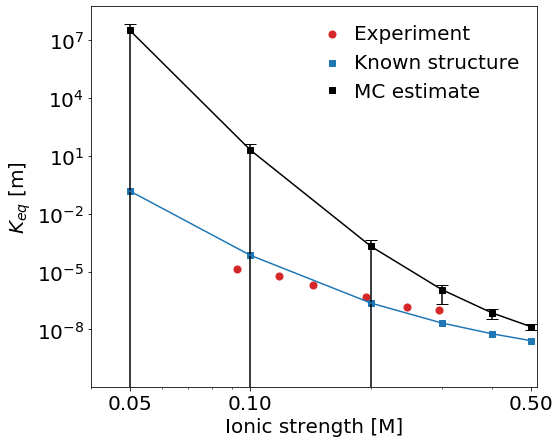

In [227]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)
ax.set_xlabel('Ionic strength [M]')
ax.set_ylabel(r'$K_{eq}$ [m]')
ax.set_yscale('log')
ax.set_xscale('log')
# # axs.set_ylim(7e-9, 1e-5)
# ax.set_ylim(7e-9, 1e-4)
ax.set_xlim(0.04, 0.52)
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks([0.05, 0.1, 0.5])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Plot experimental data
df_exp = get_exp_data(protein, resin)
ax.scatter(df_exp['IS(M)'], df_exp['Keq'], marker='o', s=50, label='Experiment',
           color='#d62728')  

# Plot prediction from known structure
for a in protein_folders:
    if a[:8] != protein:
        pass
    else:
        ion_str     = get_ion_str_from_protein_name(a)
        integrand_df_file = resin + '_' + a + '.csv'
        Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
        res[a] = Keq

for key in species_pH:
    if key[:8] != protein:
        pass
    else:
        ion_str = []
        Keq = []
        for rkey in res:
            if rkey[:rkey.rfind('_')] == key:
                ion_str.append(get_ion_str_from_protein_name(rkey))
                Keq.append(res[rkey])
        order = np.argsort(ion_str)
        xs = np.array(ion_str)[order]
        ys = np.array(Keq)[order]
        ax.scatter(xs, ys, marker='s', label='Known structure')
        ax.plot(xs, ys)

# Plot means with confidence intervals (invoking the central limit theorem here)
means   = []
lo_errs = []
hi_errs = []

for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1.0e3))
    df_keq = pd.read_csv(mc_keq_dir + ion_str_string + '.csv', index_col=0)
    
    (ci_l, mean, ci_h) = ci_t_95(df_keq['keq_m'])
    means.append(mean)
    lo_errs.append(mean - ci_l)
    hi_errs.append(ci_h - mean)

ax.errorbar(ion_str_list, means, yerr=[lo_errs, hi_errs], label='MC estimate',
            fmt='s', markersize=6, capsize=6, color='black')
ax.plot(ion_str_list, means, color=plt.gca().lines[-1].get_color(), markersize=0.1)


handles, labels = ax.get_legend_handles_labels()
new_handles = []
for h in handles:
    #only need to edit the errorbar legend entries
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)
ax.legend(new_handles, labels, loc='best', frameon=False, handletextpad=0.1)

fig.savefig(dir_distin + 'mc_keq_estimates_CI.png', bbox_inches='tight', dpi = 300)

### Generate plot
Using box and whisker plots to represent MC results

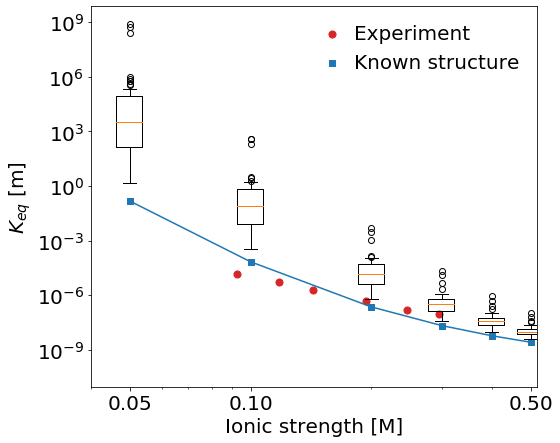

In [235]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)
ax.set_xlabel('Ionic strength [M]')
ax.set_ylabel(r'$K_{eq}$ [m]')
ax.set_yscale('log')
ax.set_xscale('log')
# # axs.set_ylim(7e-9, 1e-5)
# ax.set_ylim(7e-9, 1e-4)

# Plot experimental data
df_exp = get_exp_data(protein, resin)
ax.scatter(df_exp['IS(M)'], df_exp['Keq'], marker='o', s=50, label='Experiment',
           color='#d62728')  

# Plot prediction from known structure
for a in protein_folders:
    if a[:8] != protein:
        pass
    else:
        ion_str     = get_ion_str_from_protein_name(a)
        integrand_df_file = resin + '_' + a + '.csv'
        Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
        res[a] = Keq

for key in species_pH:
    if key[:8] != protein:
        pass
    else:
        ion_str = []
        Keq = []
        for rkey in res:
            if rkey[:rkey.rfind('_')] == key:
                ion_str.append(get_ion_str_from_protein_name(rkey))
                Keq.append(res[rkey])
        order = np.argsort(ion_str)
        xs = np.array(ion_str)[order]
        ys = np.array(Keq)[order]
        ax.scatter(xs, ys, marker='s', label='Known structure')
        ax.plot(xs, ys)

# Plot box and whisker plots
data = []
for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1.0e3))
    df_keq = pd.read_csv(mc_keq_dir + ion_str_string + '.csv', index_col=0)
    data.append(list(df_keq['keq_m']))

widths = []
factor = 0.15
for ion_str in ion_str_list:
    widths.append(factor*ion_str)
    
plt.boxplot(data, positions=ion_str_list, widths=widths)



ax.set_xlim(0.04, 0.52)
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks([0.05, 0.1, 0.5])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

handles, labels = ax.get_legend_handles_labels()
new_handles = []
for h in handles:
    #only need to edit the errorbar legend entries
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)
ax.legend(new_handles, labels, loc='best', frameon=False, handletextpad=0.1)

fig.savefig(dir_distin + 'mc_keq_estimates_box_and_whisker.png', 
            bbox_inches='tight', dpi = 300)

### Plot Keq histograms

Choose one

In [184]:
protein  = 'lys_pH_7'
resin    = 'sep'

In [180]:
protein  = 'ova_pH_7'
resin    = 'phq'

Generate plot

In [185]:
prot_dir   = 'ns_bim_spherical/ns_bim_programs/' + protein + '/'
mc_keq_dir = prot_dir + 'mc_keq_results/'
dir_distin = 'ns_bim_spherical/images_general/monte_carlo/' + protein + '/'

Creation of the directory ns_bim_spherical/images_general/monte_carlo/lys_pH_7/keq_histograms/ failed


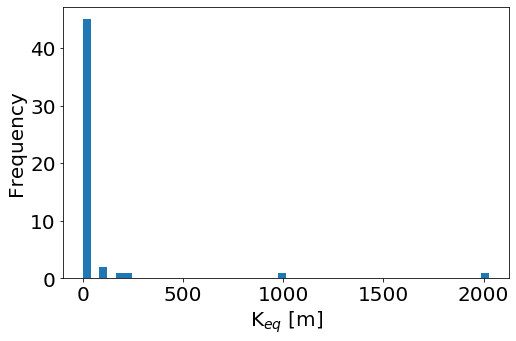

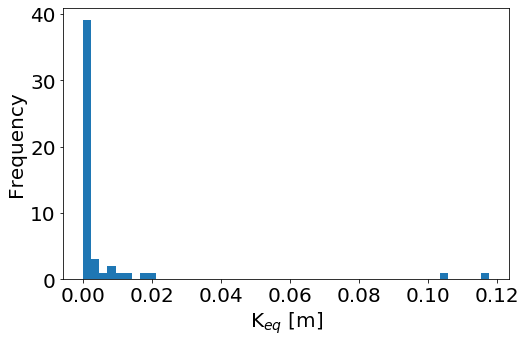

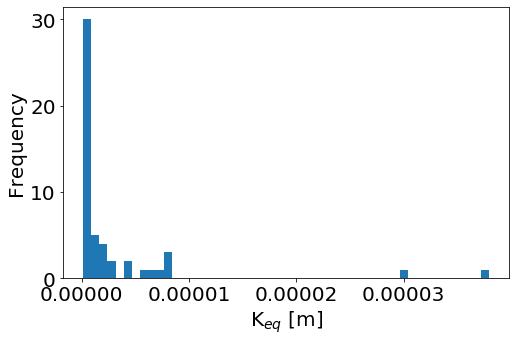

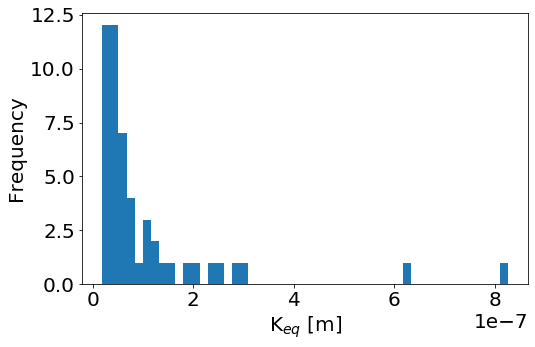

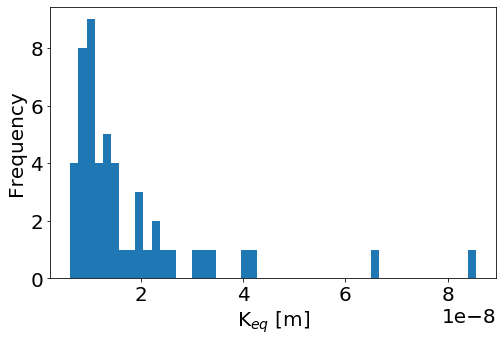

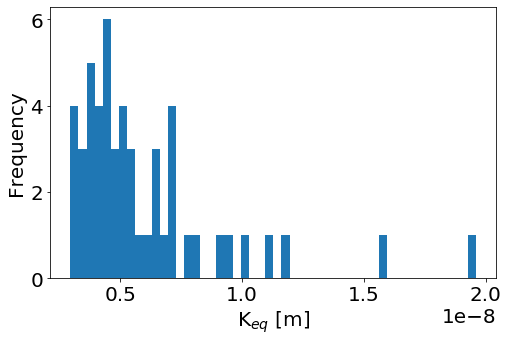

In [186]:
sub_distin = dir_distin + 'keq_histograms/'
my_mk_dir(sub_distin)

for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1.0e3))
    df_keq = pd.read_csv(mc_keq_dir + ion_str_string + '.csv', index_col=0)
    
    fig, ax = plt.subplots()
    font = {'weight': 'normal', 'size': 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 5, forward=True)
    ax.set_ylabel('Frequency')

    ax.set_xlabel(r'K$_{eq}$ [m]')
    ax.hist(df_keq['keq_m'], 50, density=False)
    fig.savefig(sub_distin + ion_str_string + '.png', bbox_inches='tight', dpi=300)
    

## Count the numer of histidines in each species

In [44]:
totals     = []
histidines = []

for ind, protein in enumerate(protein_folders): 
    fort_file  = 'ns_bim_spherical/ns_bim_programs/' + protein + '/fort.3'
    df_charges = pd.read_fwf(fort_file, skiprows=1,names=['x_A', 'y_A', 'z_A', 'q', 
                            'residue', 'res_num', 'chain', 'unk'], infer_nrows=1000)
    
    n_his = 0
    for ind, content in df_charges.iterrows():
        if content['residue'] == 'HIS':
            n_his += 1
    totals.append(len(df_charges))
    histidines.append(n_his)

histidines.pop(3)
totals.pop(3)
protein_folders.pop(3)
histidines.pop(3)
totals.pop(3)
protein_folders.pop(4)

print(totals)

[384, 100, 644, 33, 84]


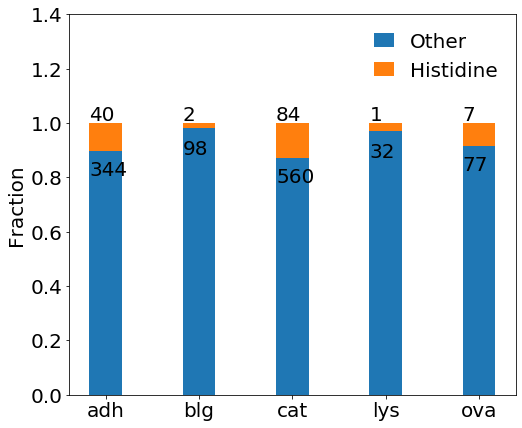

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
ax.set_ylabel('Fraction')
ax.set_ylim(0, 1.4)

frac_his = []
frac_not = []
for n_his, n_total in zip(histidines, totals):
    temp_frac_his = n_his/n_total
    frac_his.append(temp_frac_his)
    frac_not.append(1 - temp_frac_his)
    
ind = np.arange(len(protein_folders))
width = 0.35
p1 = ax.bar(ind, frac_not, width)
p2 = ax.bar(ind, frac_his, width, bottom=frac_not)
names = [x[:3] for x in protein_folders]
plt.xticks(ind, names)
plt.legend((p1[0], p2[0]), ('Other', 'Histidine'), loc='upper right', handlelength=1, 
          frameon=False)

for ind, p in enumerate(p1):
    plt.text(p.get_x(), p.get_height()*0.9, '{}'.format(totals[ind]-histidines[ind]))
    plt.text(p.get_x(), 1.01, '{}'.format(histidines[ind]))
    
fig.savefig('ns_bim_spherical/results/images/n_histidines.png', 
            bbox_inches='tight', dpi = 300)

In [48]:
for p, f in zip(protein_folders, frac_his):
    print(p, f)

adh_pH_7 0.10416666666666667
blg_pH_7 0.02
cat_pH_7 0.13043478260869565
lys_pH_7 0.030303030303030304
ova_pH_7 0.08333333333333333


## Plot charge density vs potential

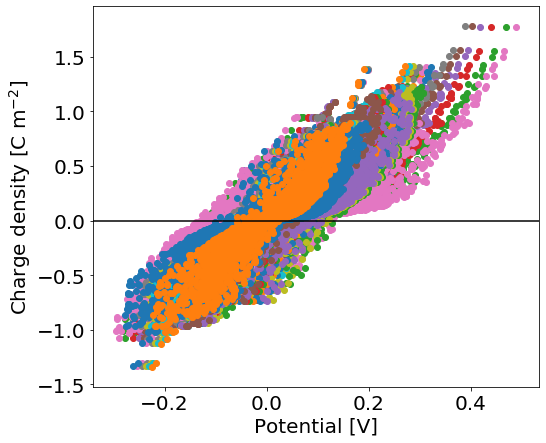

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
ax.set_xlabel('Potential [V]')
ax.set_ylabel(r'Charge density [C m$^{-2}$]')
# ax.set_ylim(-0.002, 0.002)
ax.axhline(color='black')

for protein in protein_folders:
    ax.scatter(elements_dict[protein]['potential_V'], 
               elements_dict[protein]['charge_C_m2'])
    
fig.savefig('ns_bim_spherical/results/images/correlation_potential_charge.png', 
            bbox_inches='tight', dpi = 300)

In [48]:
mins = []
maxs = []

for protein in protein_folders:
    mins.append(min(elements_dict[protein]['charge_C_m2']))
    maxs.append(max(elements_dict[protein]['charge_C_m2']))
    
global_min = min(mins)
global_max = max(maxs)

print(global_min, global_max)

-0.00133626271467 0.0017802146472233333


# Correlation of surface potential and integral contribution

In [4]:
base_names = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7', 'lys_pH_5', 'lys_pH_7', 'lys_pH_9', 
              'ova_pH_7']

### For data based on PDB2PQR partial charges

In [5]:
results_dir = 'results_pqr_partial_charges'
z0          = 3.0e-10 

nsbim_data_dir   = 'ns_bim_spherical/' + results_dir + '/ns_bim_data/'
integrand_dir    = 'ns_bim_spherical/' + results_dir + '/integrand_results/'
integral_dir     = 'ns_bim_spherical/' + results_dir + '/integral_results/'
sum_contribs_dir = 'ns_bim_spherical/' + results_dir + '/summed_integral_contribs/'
images_dir       = 'ns_bim_spherical/' + results_dir + '/images/'

my_mk_dir(integral_dir)
my_mk_dir(sum_contribs_dir)

Creation of the directory ns_bim_spherical/results_pqr_partial_charges/integral_results/ failed
Creation of the directory ns_bim_spherical/results_pqr_partial_charges/summed_integral_contribs/ failed


For AEX

In [6]:
resins      = ['caq', 'phq', 'pxq']

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders = [i for i in protein_folders if i[:3] != 'lys']       # NB
protein_folders

['adh_pH_7_100',
 'adh_pH_7_200',
 'adh_pH_7_300',
 'adh_pH_7_400',
 'adh_pH_7_50',
 'adh_pH_7_500',
 'blg_pH_7_100',
 'blg_pH_7_200',
 'blg_pH_7_300',
 'blg_pH_7_400',
 'blg_pH_7_50',
 'blg_pH_7_500',
 'cat_pH_7_100',
 'cat_pH_7_200',
 'cat_pH_7_300',
 'cat_pH_7_400',
 'cat_pH_7_50',
 'cat_pH_7_500',
 'ova_pH_7_100',
 'ova_pH_7_200',
 'ova_pH_7_300',
 'ova_pH_7_400',
 'ova_pH_7_50',
 'ova_pH_7_500']

In [7]:
elements_dict, node_dict, charge_dict = get_elem_and_node_dicts(nsbim_data_dir, protein_folders)
elements_dict = fill_elem_dict(elements_dict, node_dict, protein_folders)

In [12]:
args_list = []
for resin in resins:
    for protein in protein_folders[-7:]:
        elements_df       = elements_dict[protein].copy()
        integrand_df_file = integrand_dir + resin + '_' + protein + '.csv'
        new_file          = integral_dir + resin + '_' + protein + '.csv'
        args = (resin, protein, elements_df, integrand_df_file, z0, new_file)
        args_list.append(args)


In [ ]:
pool      = mp.Pool(processes = mp.cpu_count())
results   = pool.map(get_and_save_integral_contribs, args_list)
pool.close()
pool.join()

In [ ]:
def plot_histogram_contribs(args):
    (resin, protein, integral_dir) = args
    try:
        df = pd.read_csv(integral_dir + resin + '_' + protein + '.csv')
    except:
        print('Repeat calculations for ' + resin + '_' + protein)
    else:
        fig, ax = plt.subplots()
        fig.set_size_inches(8, 7, forward=True)
        font = {'weight': 'normal', 'size': 20}
        plt.rc('font', **font)
        ax.set_xlabel('Potential [V]')
        ax.set_ylabel('Normalized histogram frequency')
        ax.text(0.03, 0.9, resin + '_' + protein, transform=ax.transAxes)

        num_bins = 200
        n_1, bins_1, rects_1 = ax.hist(df['potential_V'], num_bins, density=True,
                                       alpha=0.5)

        sums = np.zeros(len(bins_1) - 1)
        xs   = np.zeros(len(bins_1) - 1)

        for bin_i in range(len(sums)):
            xs[bin_i] = (bins_1[bin_i] + bins_1[bin_i +1])/2
            for j, cont in df.iterrows():
                if bins_1[bin_i] <= cont['potential_V'] < bins_1[bin_i + 1]:
                    sums[bin_i] += cont['integral']

        ax2 = ax.twinx()
        ax2.set_ylabel('Summed integral contributions [m]')
        ax2.plot(xs, sums, color='#ff7f0e')

        ax.axhline(color='black')
        align_yaxis(ax, ax2)

        df_sum_contribs = pd.DataFrame()
        df_sum_contribs['frequency']    = n_1
        df_sum_contribs['sum_contribs'] = sums
        df_sum_contribs.to_csv(sum_contribs_dir + resin + '_' + protein + '.csv', index=False)

        fig.savefig(images_dir + 'histogram_contribs/' + resin + '_' + protein + '.png', 
                    bbox_inches='tight', dpi=300)
            
args_list = []
for resin in resins:
    for protein in protein_folders:
        args_list.append((resin, protein, integral_dir))
        
pool      = mp.Pool(processes = mp.cpu_count())
results   = pool.map(plot_histogram_contribs, args_list)
pool.close()
pool.join()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


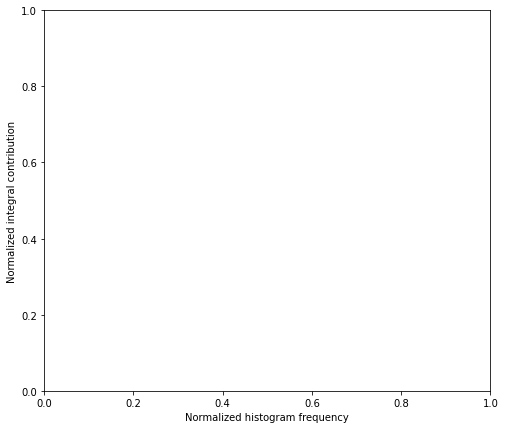

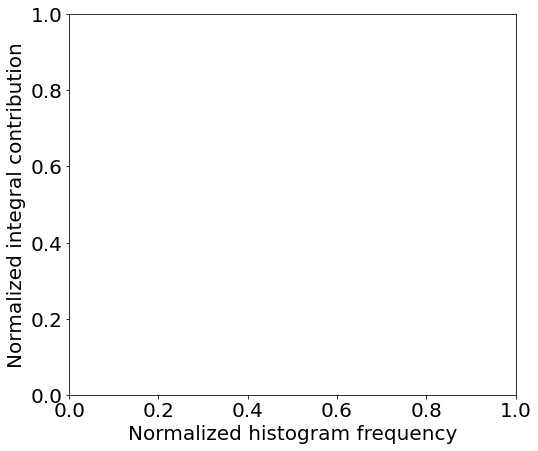

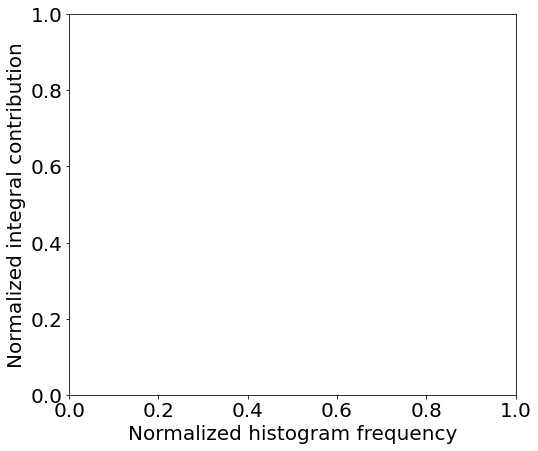

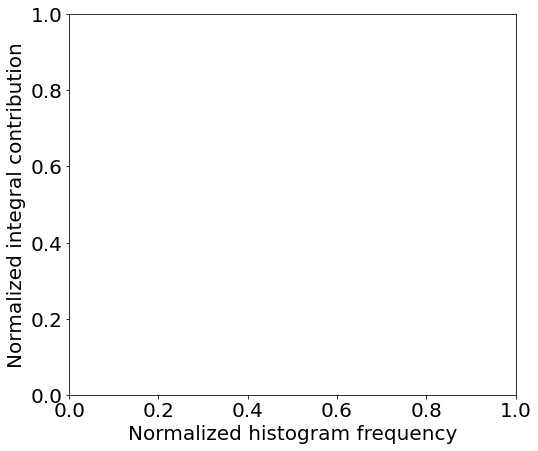

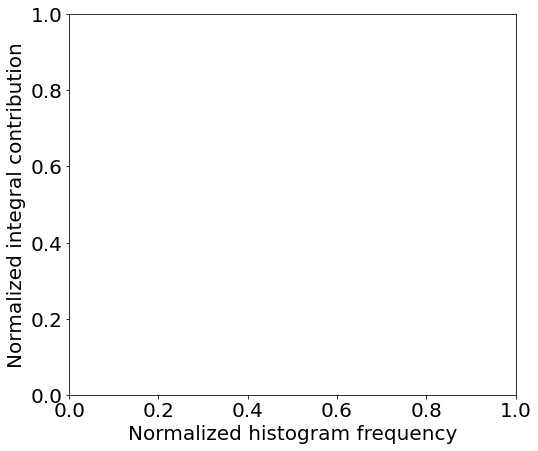

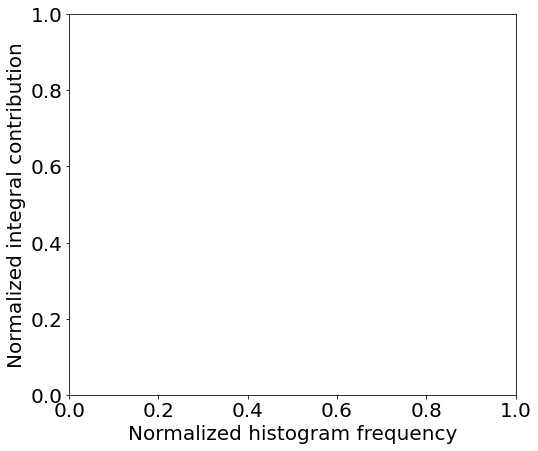

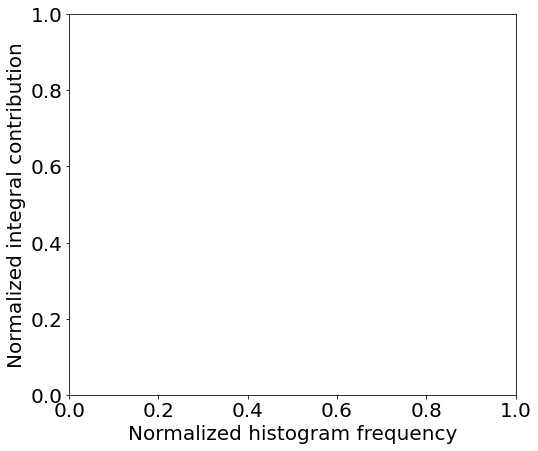

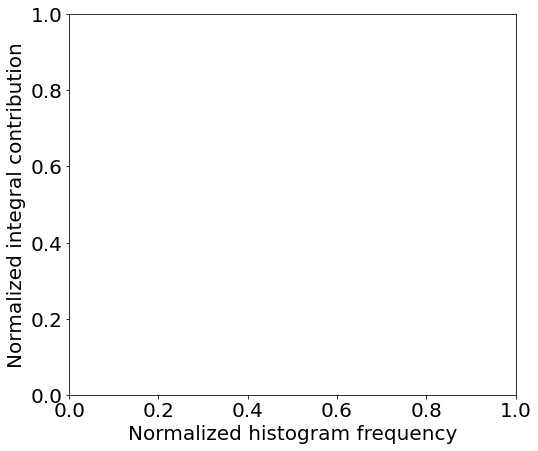

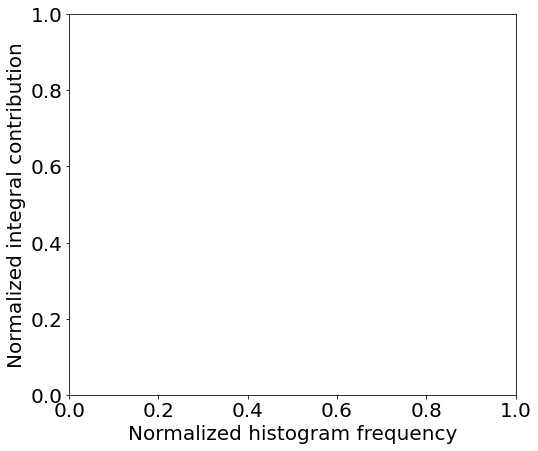

In [9]:
for name in base_names:
    if name[:3] != 'lys':
        pass
    else:
        for resin in resins:
            fig, ax = plt.subplots()
            fig.set_size_inches(8, 7, forward=True)
            font = {'weight': 'normal', 'size': 20}
            plt.rc('font', **font)
            ax.set_xlabel('Normalized histogram frequency')
            ax.set_ylabel('Normalized integral contribution')

            for protein in protein_folders:
                if name != protein[:8]:
                    pass
                else:
                    try:
                        df = pd.read_csv(sum_contribs_dir + resin + '_' + protein + '.csv')
                        ion_str = get_ion_str_from_protein_name(protein)

                        integral_sum = sum(df['sum_contribs'])
                        ax.scatter(df['frequency'], df['sum_contribs']/integral_sum, s=2,
                                  label = str(int(ion_str*1000)) + ' mM')
                    except:
                        print('Repeat calculations for ' + resin + '_' + protein)

            ax.legend(loc='upper right', frameon=False, fontsize=16)
            fig.savefig(images_dir + 'summed_integral_contribs/' + resin + '_' + name +\
                        '.png', bbox_inches='tight', dpi=300)

For CEX

In [16]:
resins      = ['sep']

protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
protein_folders = [i for i in protein_folders if i[:3] == 'lys']       # NB
protein_folders

['lys_pH_5_100',
 'lys_pH_5_200',
 'lys_pH_5_300',
 'lys_pH_5_400',
 'lys_pH_5_50',
 'lys_pH_5_500',
 'lys_pH_7_100',
 'lys_pH_7_200',
 'lys_pH_7_300',
 'lys_pH_7_400',
 'lys_pH_7_50',
 'lys_pH_7_500',
 'lys_pH_9_100',
 'lys_pH_9_200',
 'lys_pH_9_300',
 'lys_pH_9_400',
 'lys_pH_9_50',
 'lys_pH_9_500']

In [17]:
elements_dict, node_dict, charge_dict = get_elem_and_node_dicts(nsbim_data_dir, protein_folders)
elements_dict = fill_elem_dict(elements_dict, node_dict, protein_folders)

In [18]:
args_list = []
for resin in resins:
    for protein in protein_folders:
        elements_df       = elements_dict[protein].copy()
        integrand_df_file = integrand_dir + resin + '_' + protein + '.csv'
        new_file          = integral_dir + resin + '_' + protein + '.csv'
        args = (resin, protein, elements_df, integrand_df_file, z0, new_file)
        args_list.append(args)

pool      = mp.Pool(processes = mp.cpu_count())
results   = pool.map(get_and_save_integral_contribs, args_list)
pool.close()
pool.join()

Raw scatter plots

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


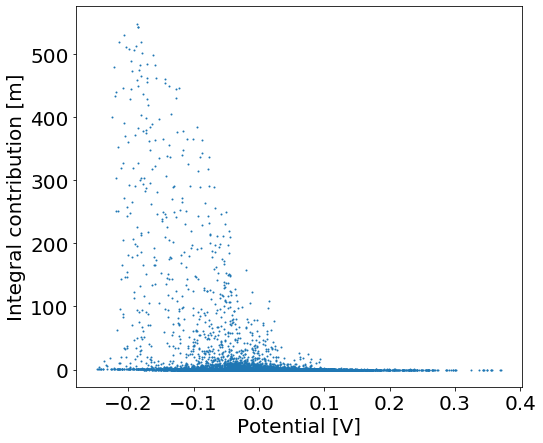

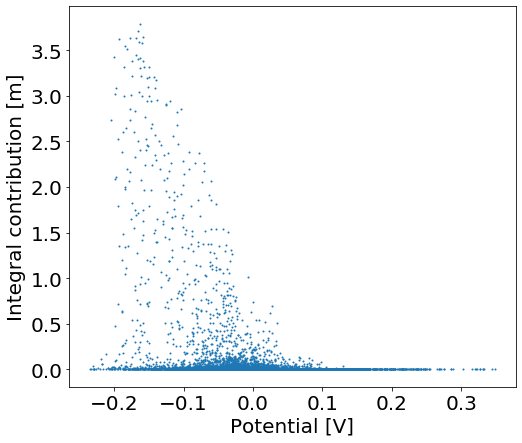

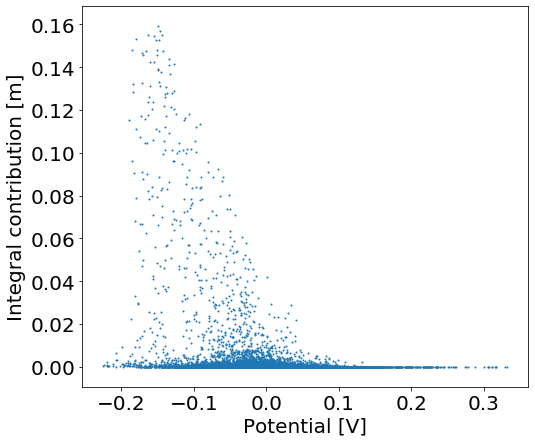

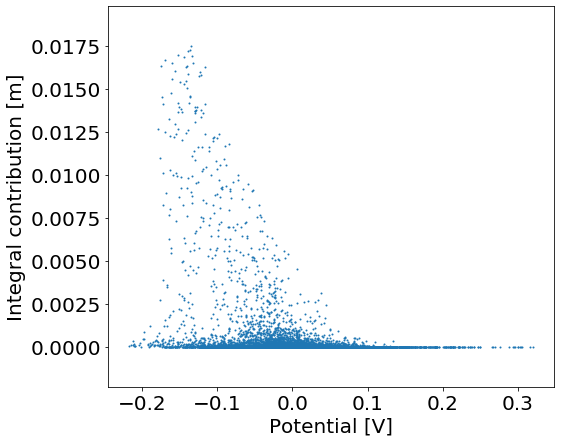

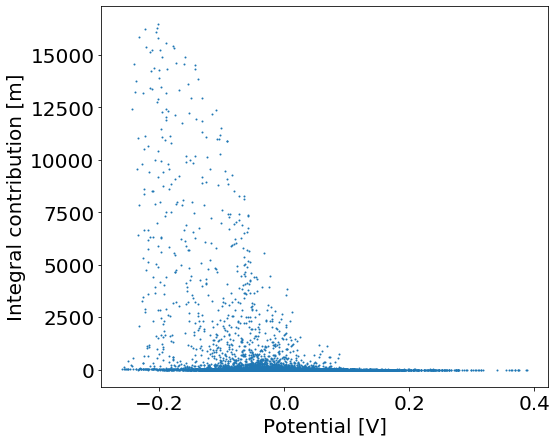

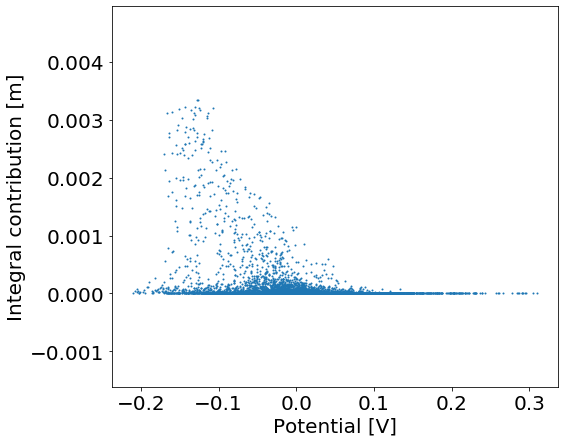

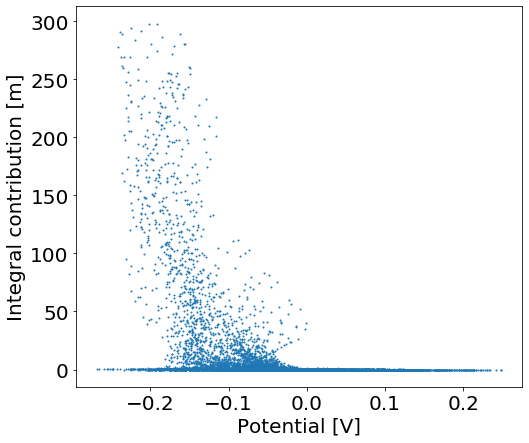

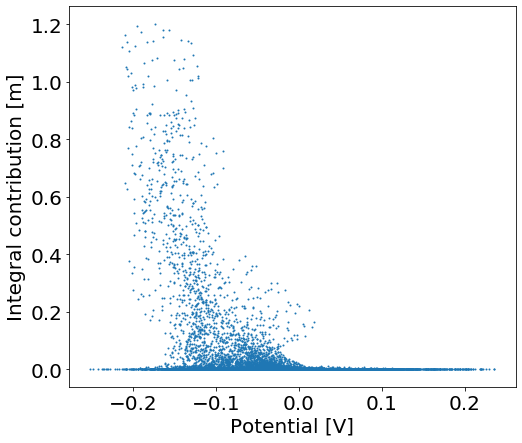

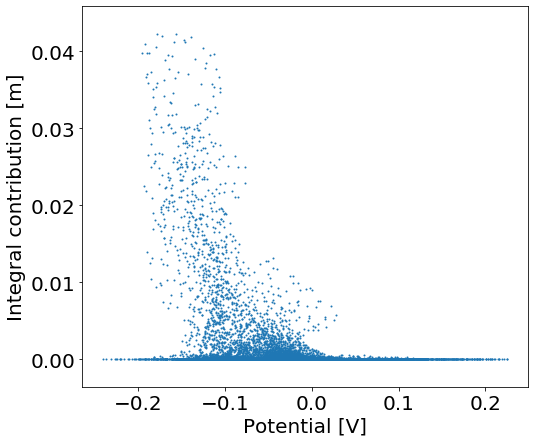

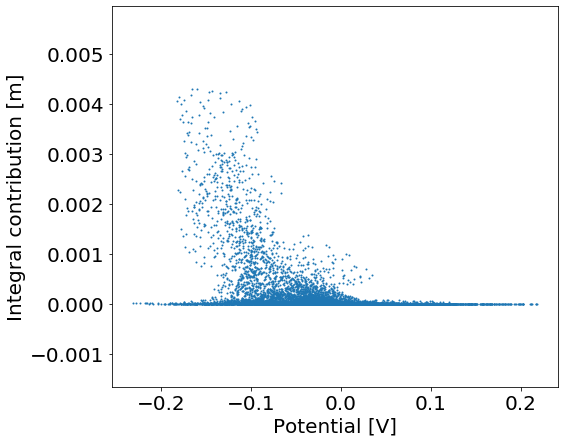

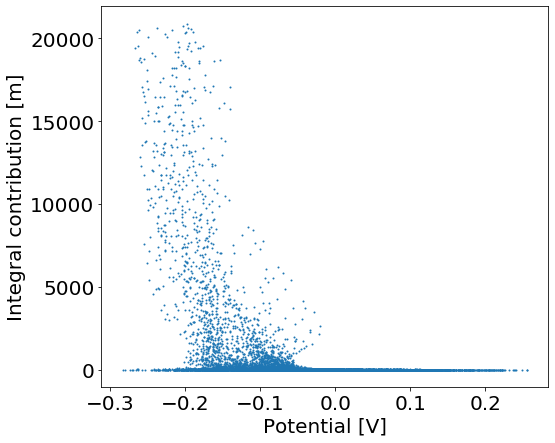

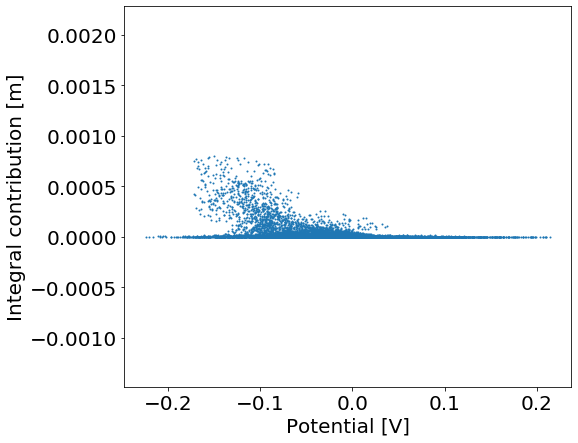

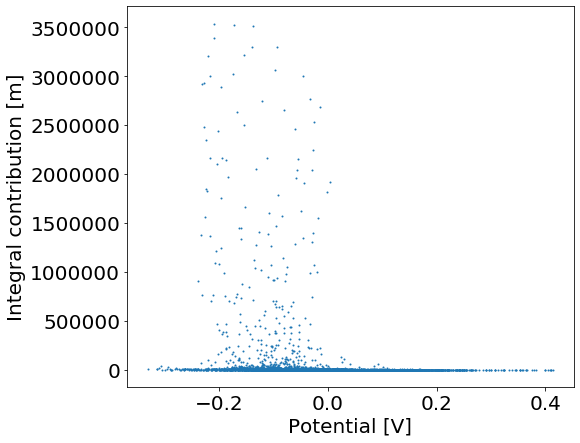

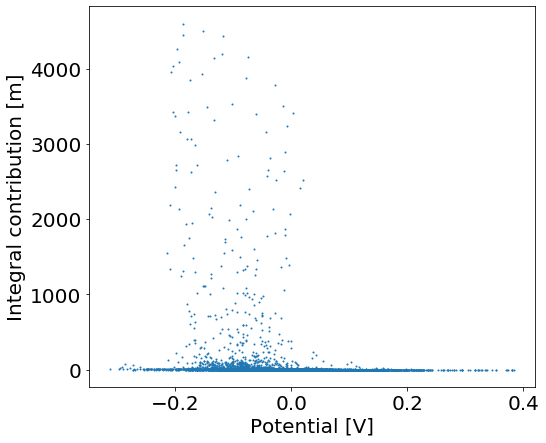

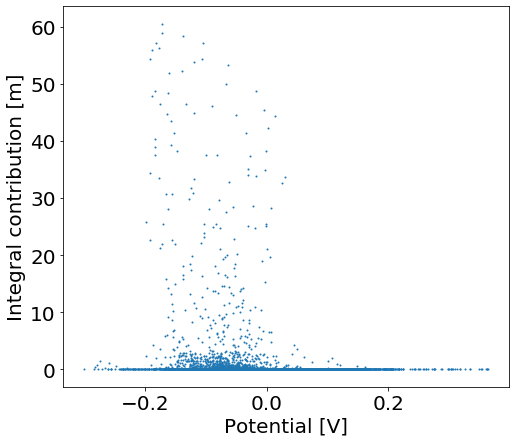

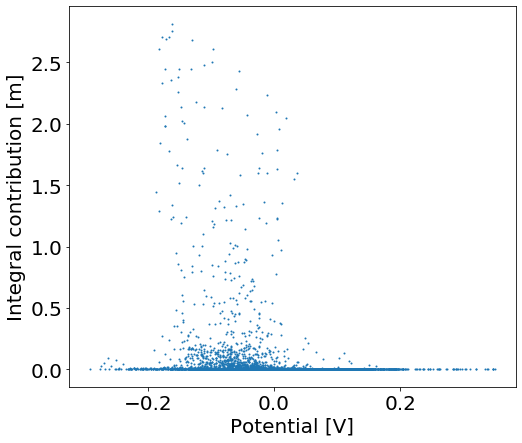

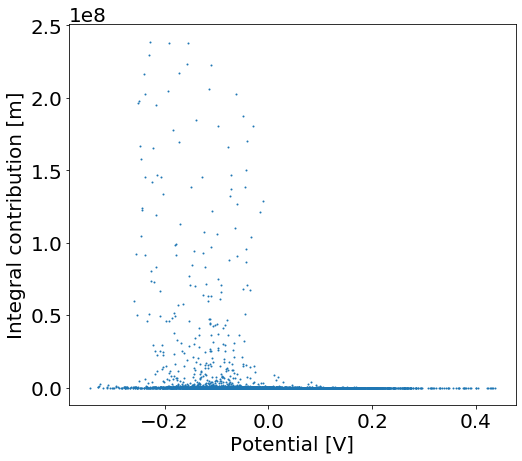

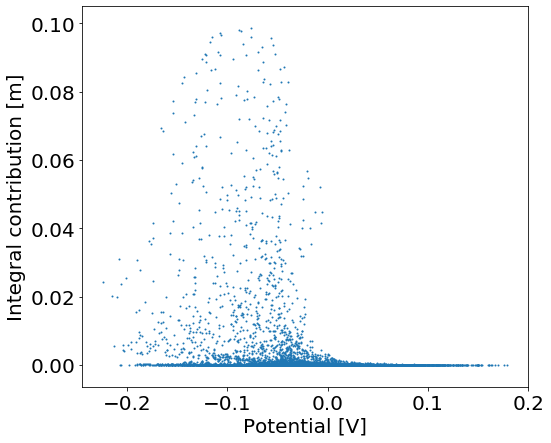

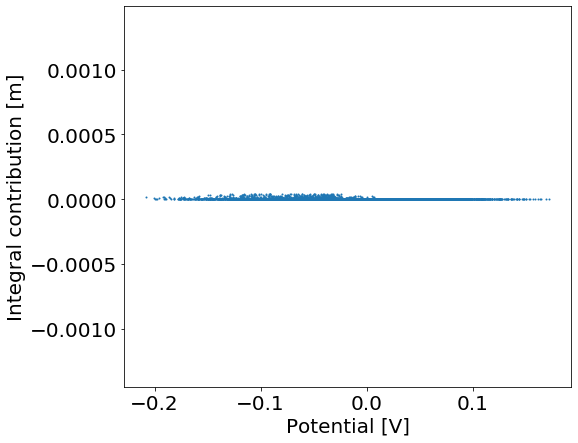

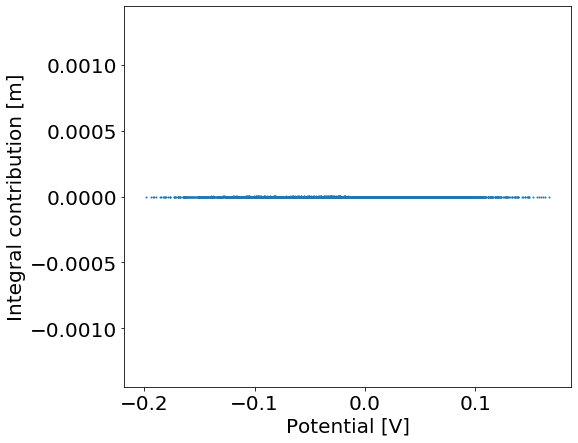

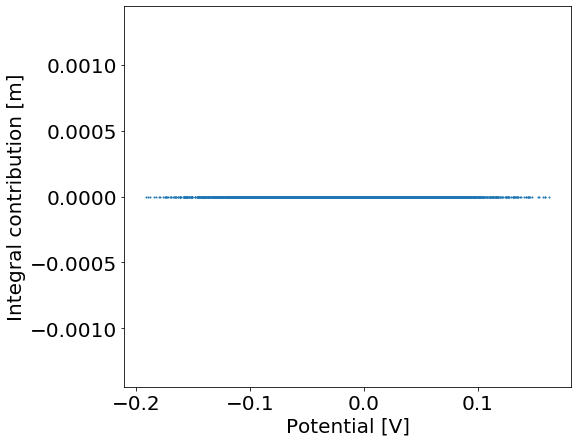

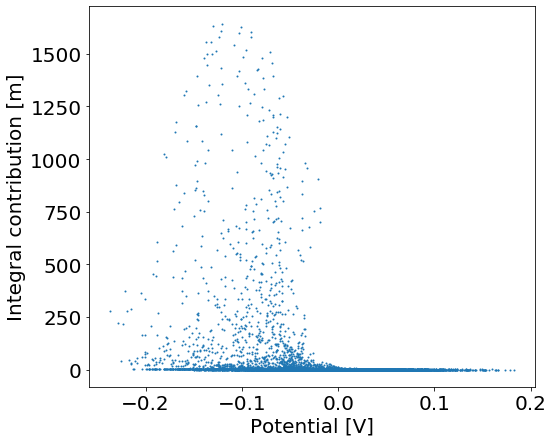

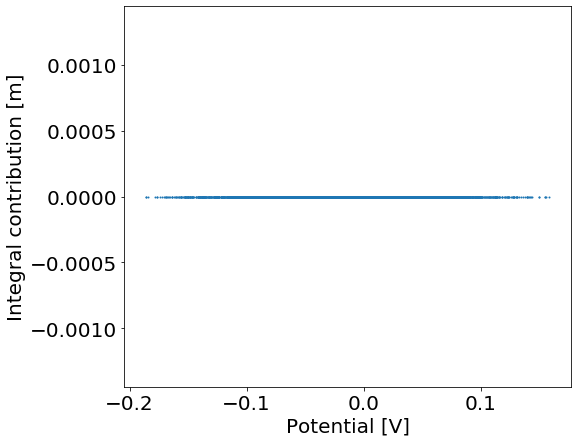

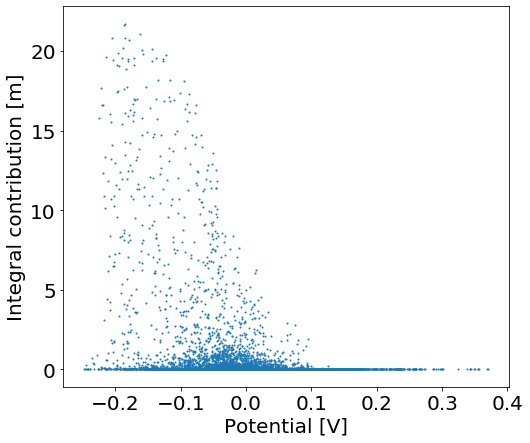

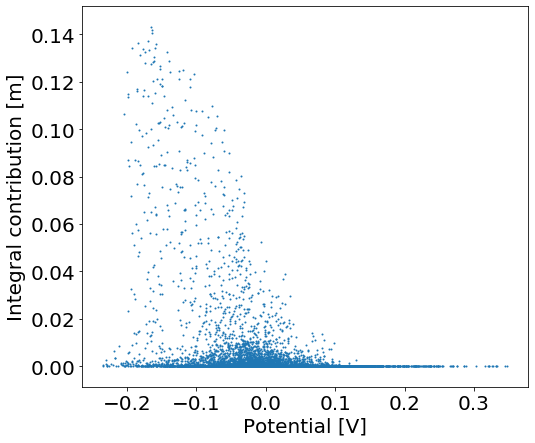

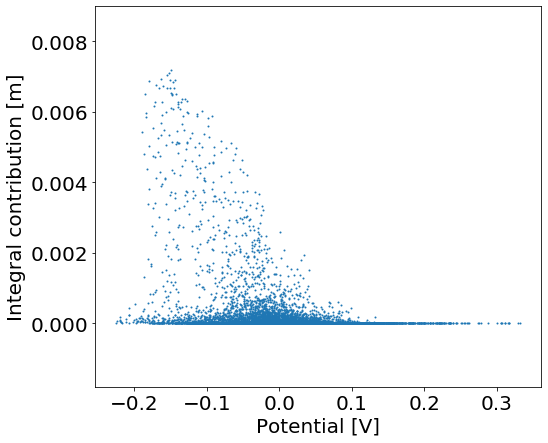

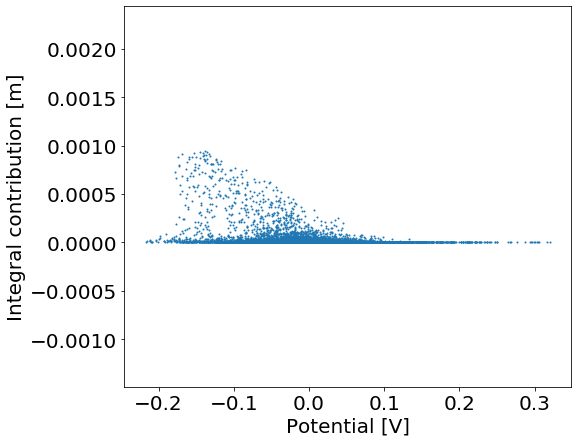

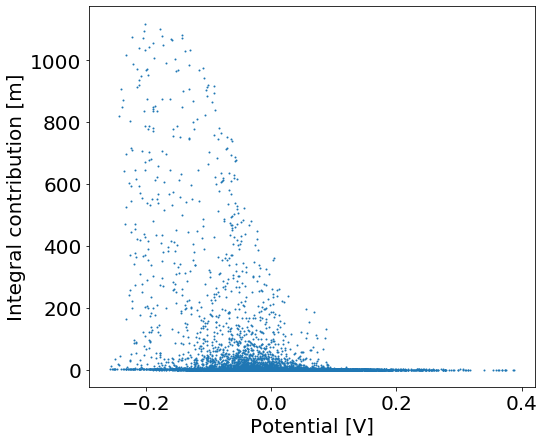

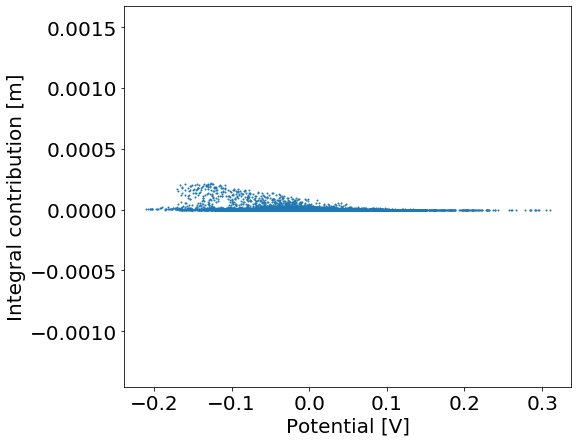

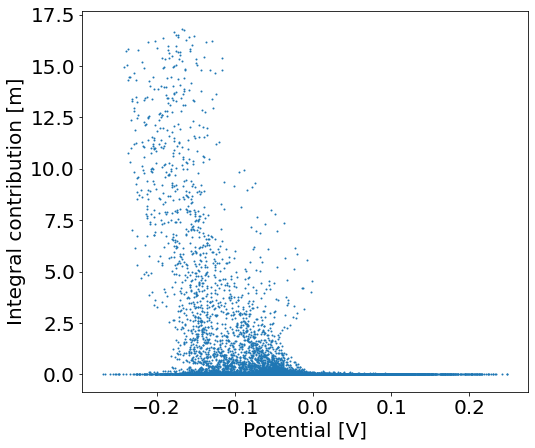

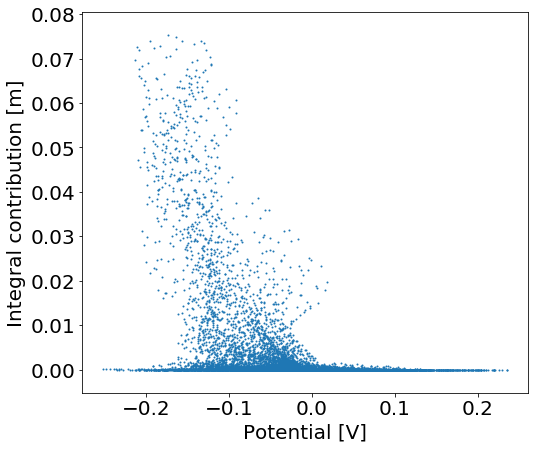

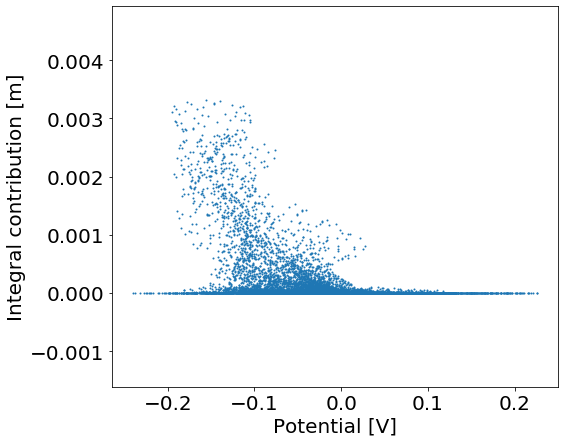

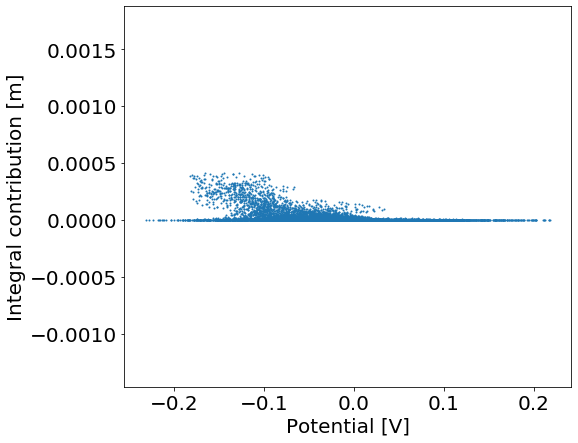

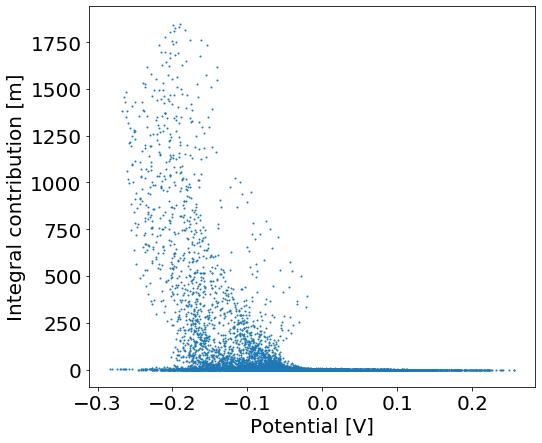

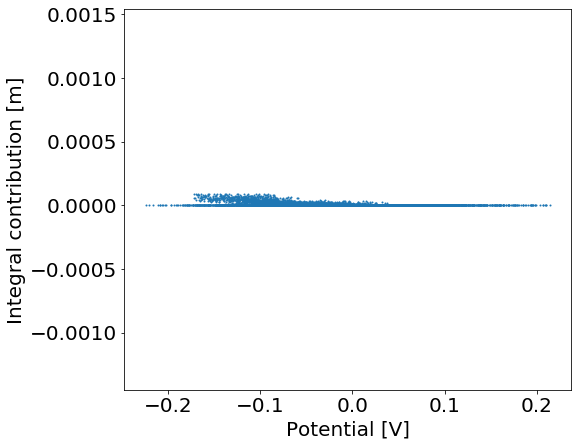

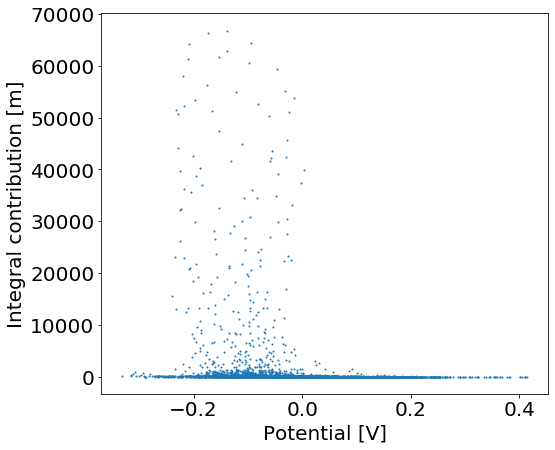

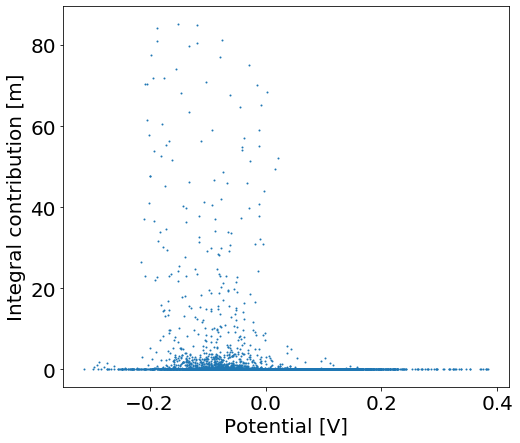

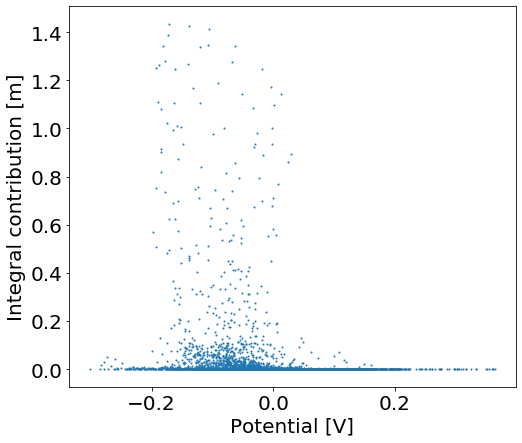

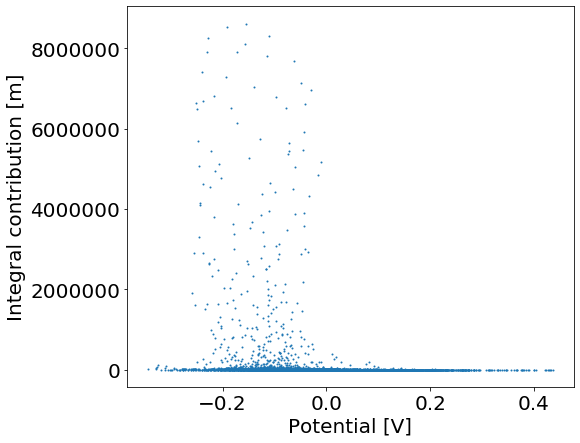

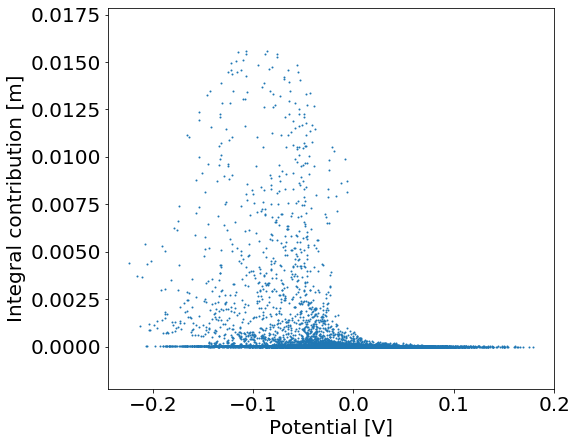

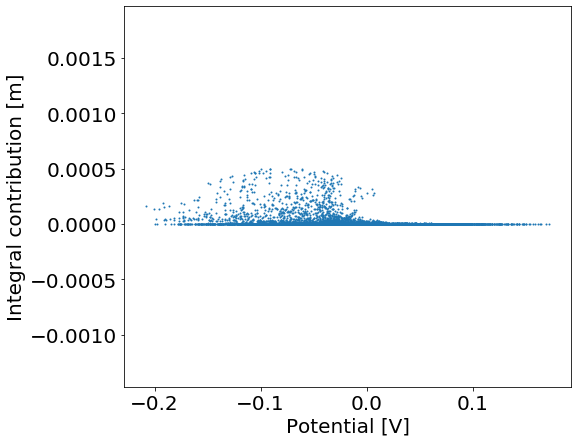

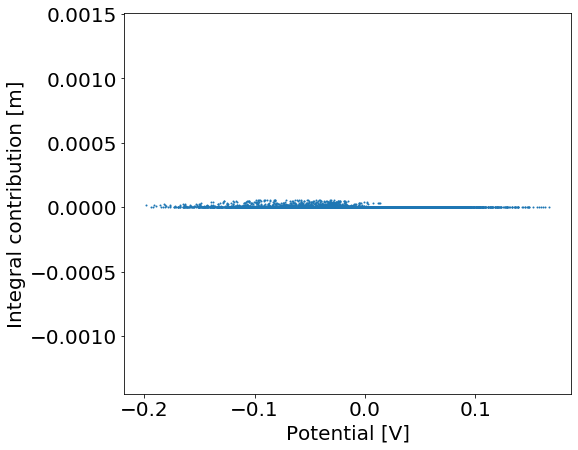

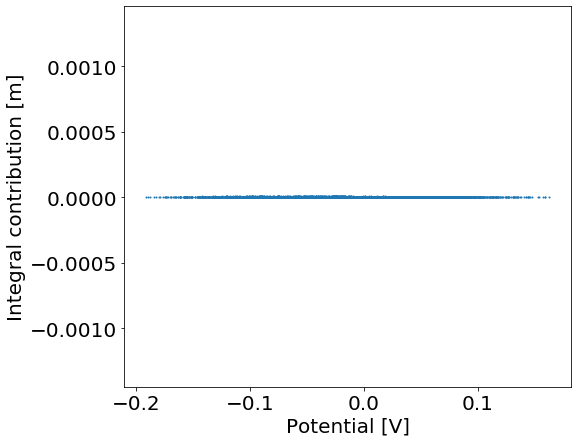

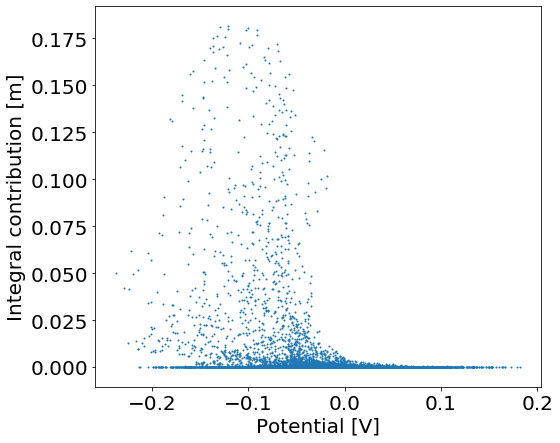

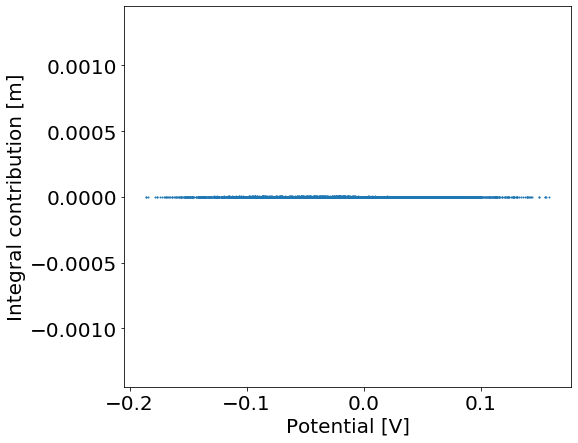

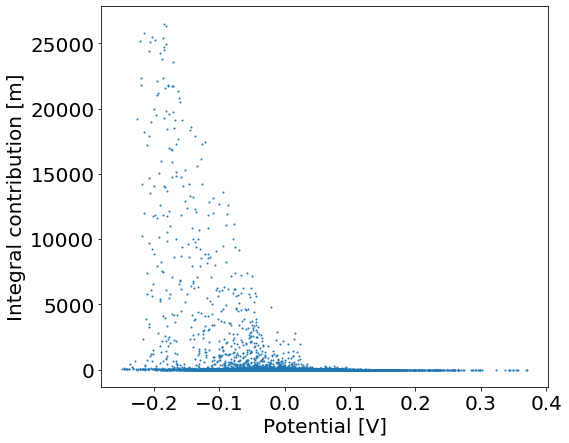

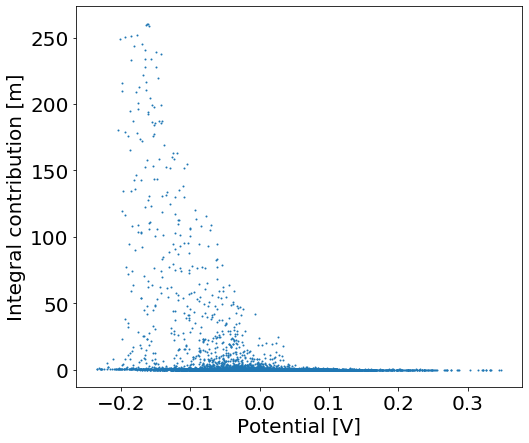

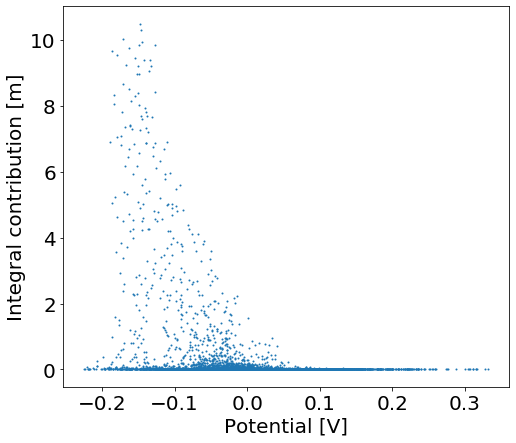

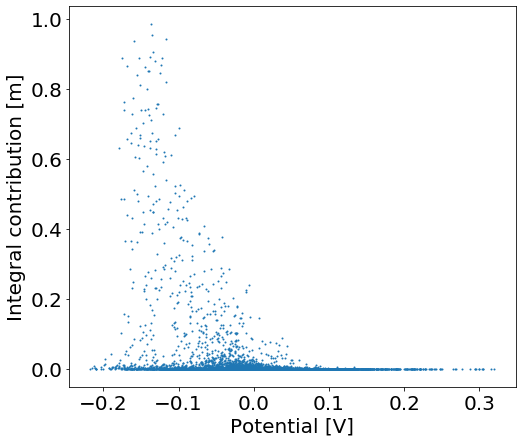

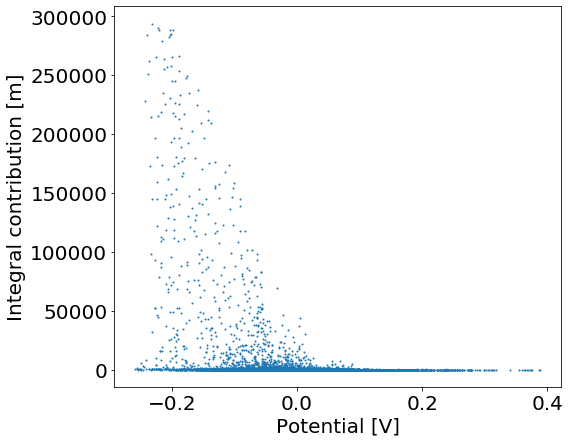

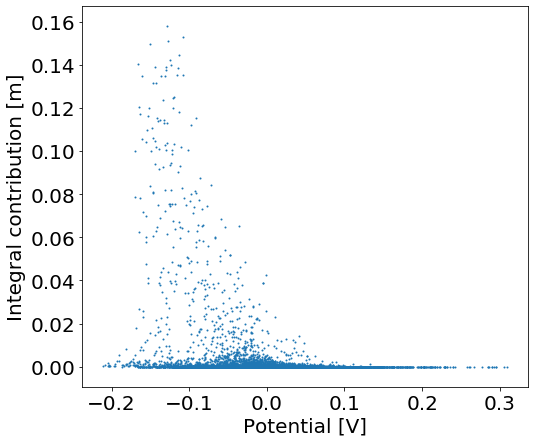

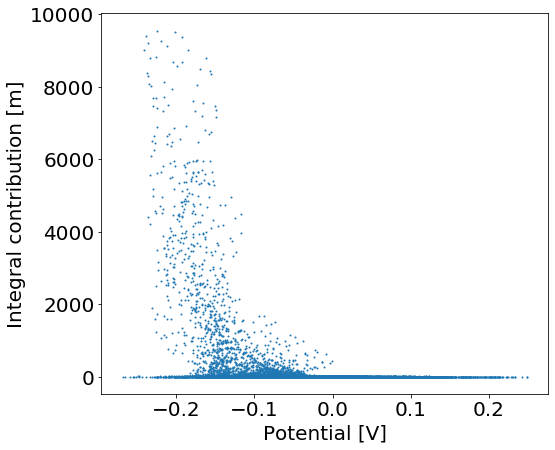

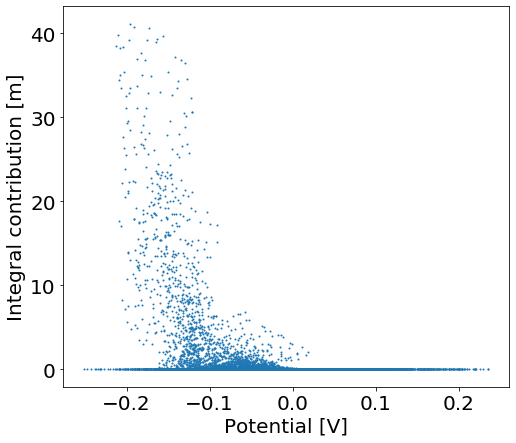

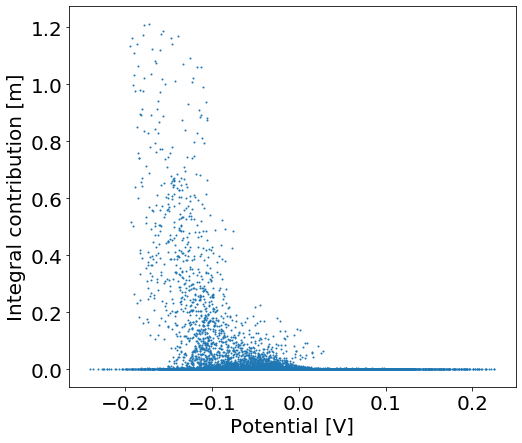

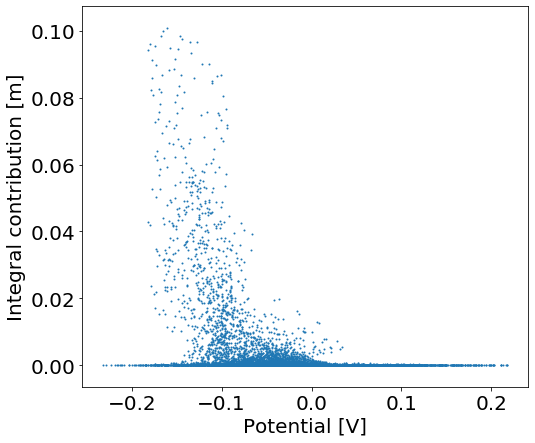

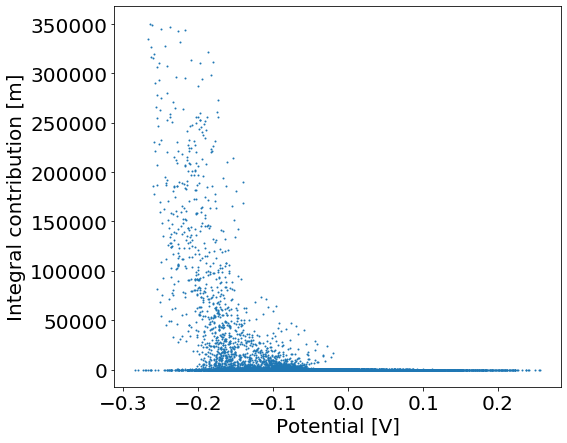

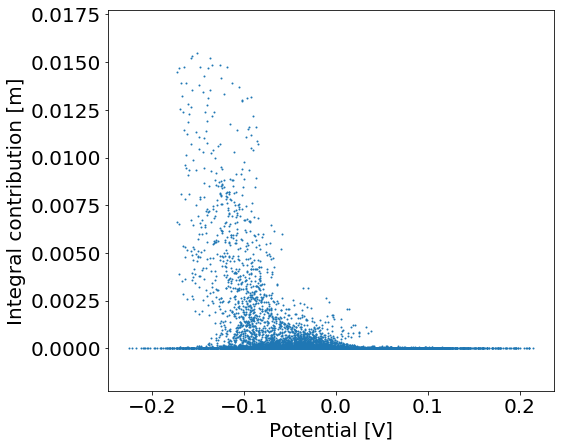

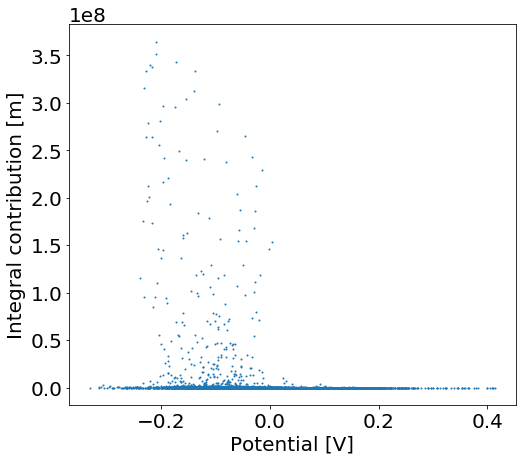

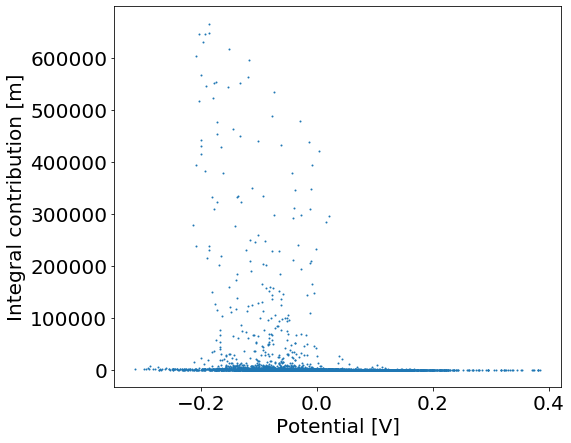

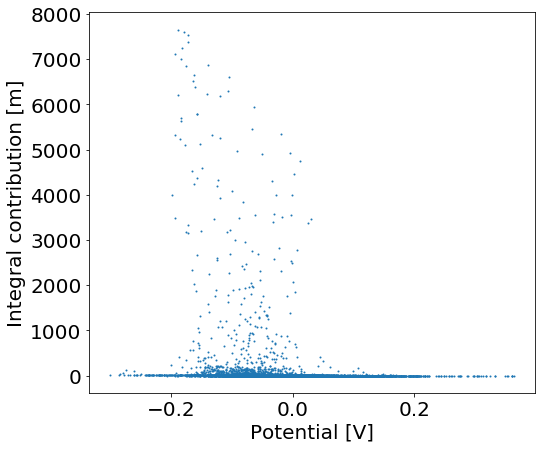

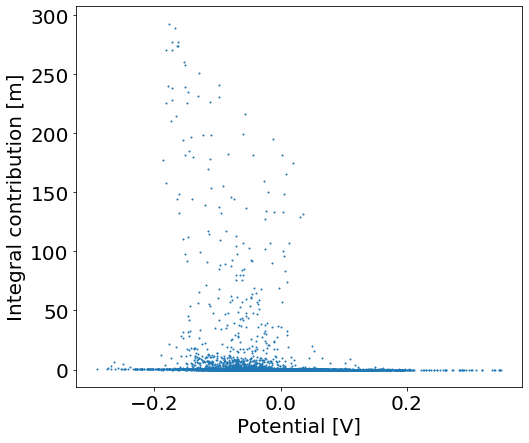

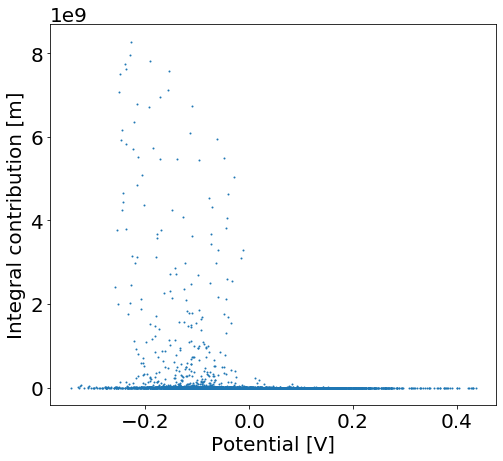

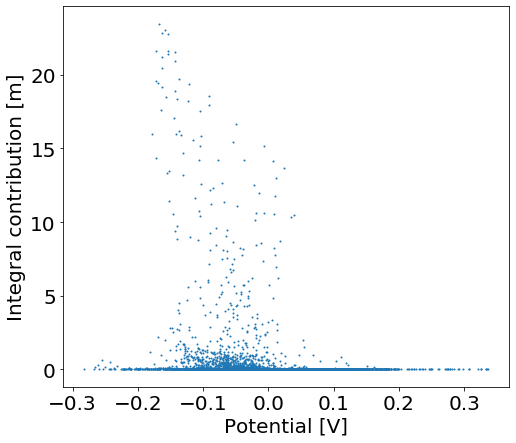

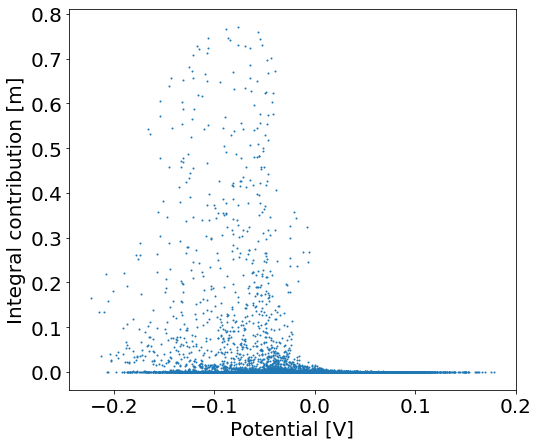

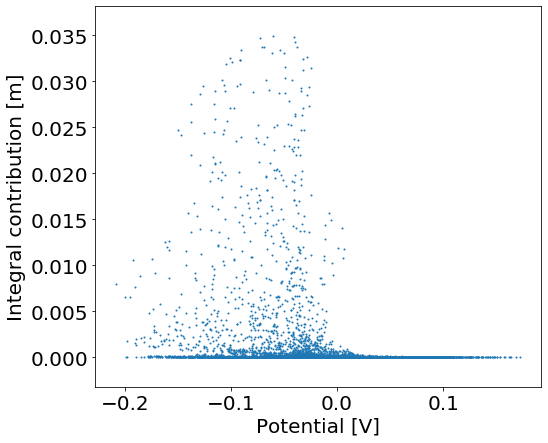

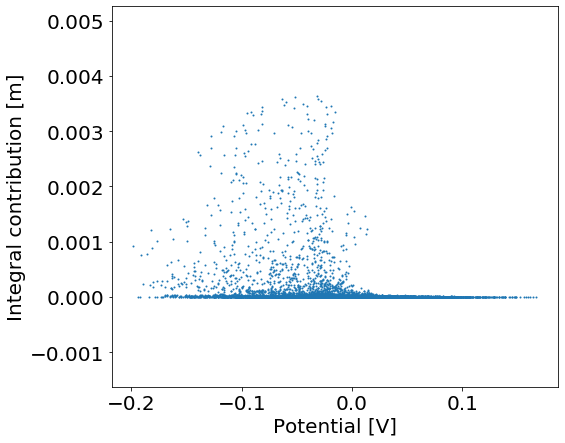

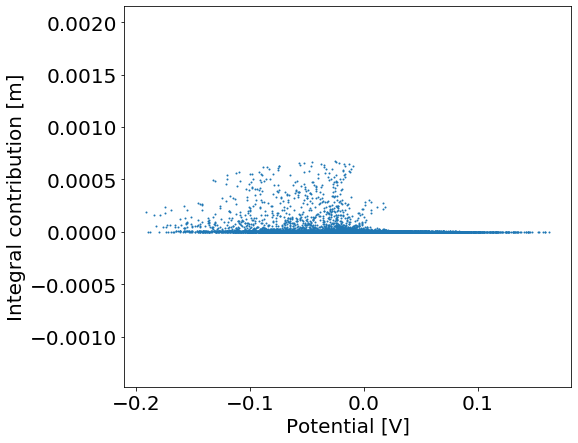

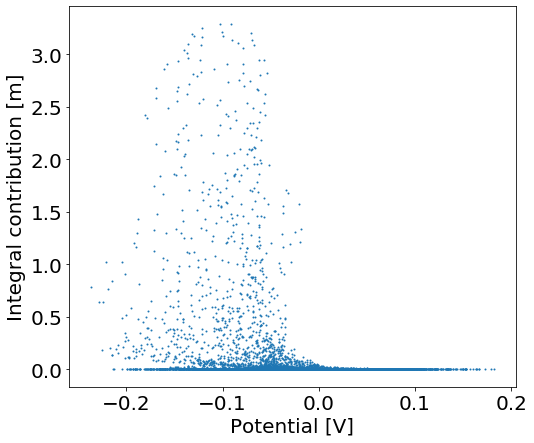

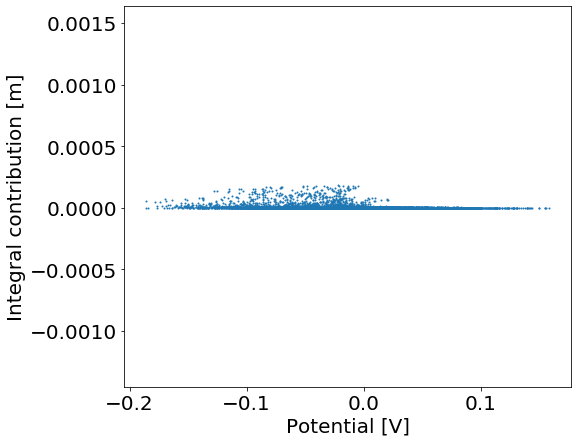

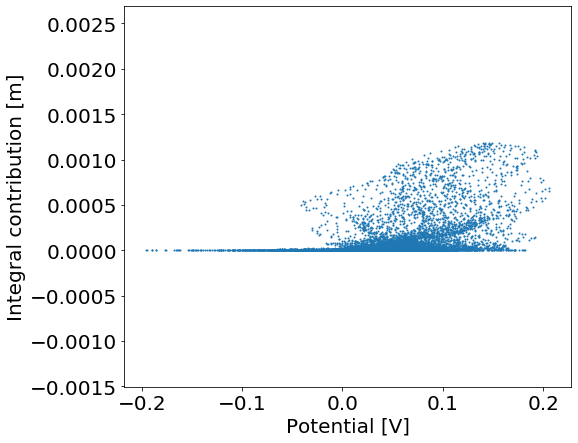

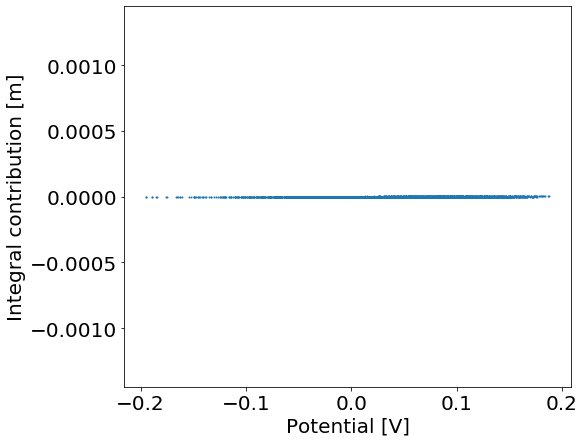

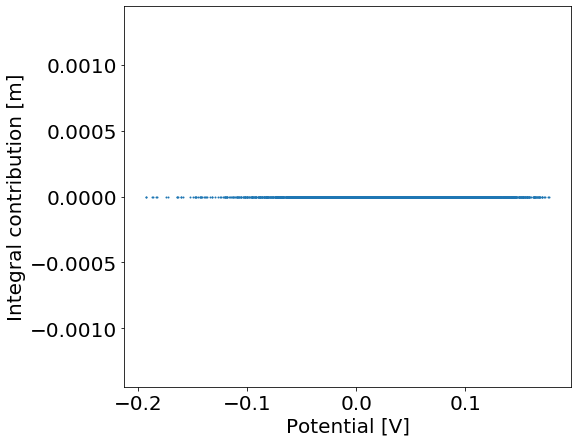

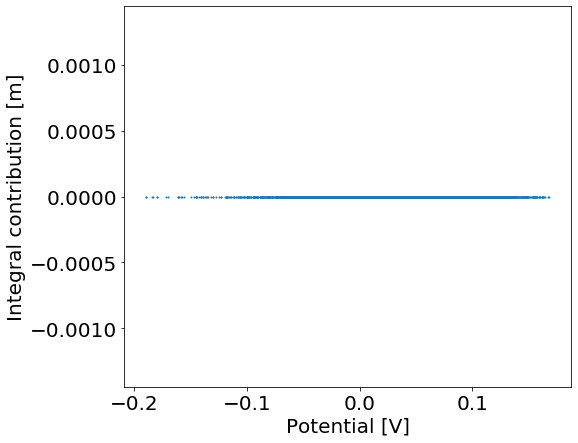

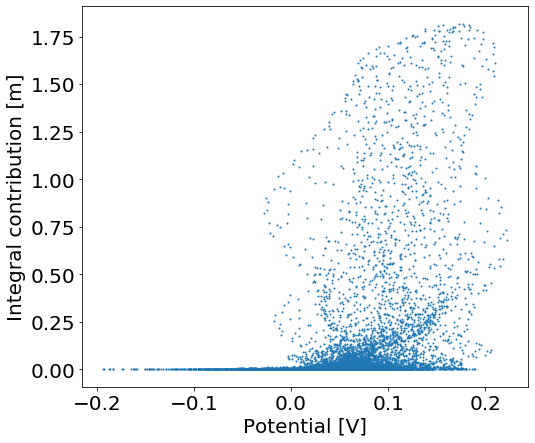

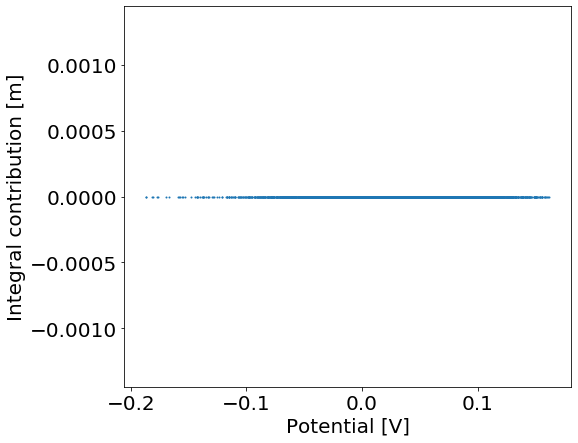

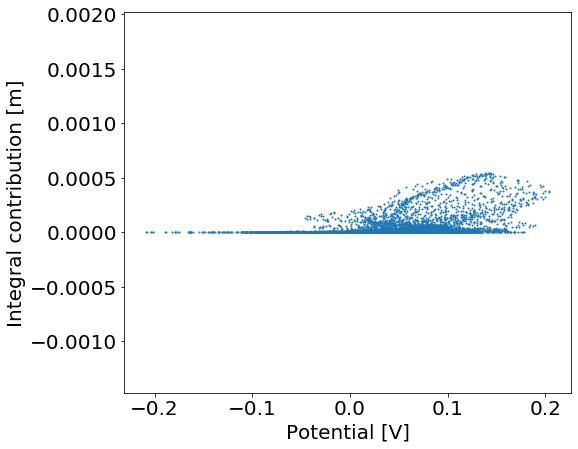

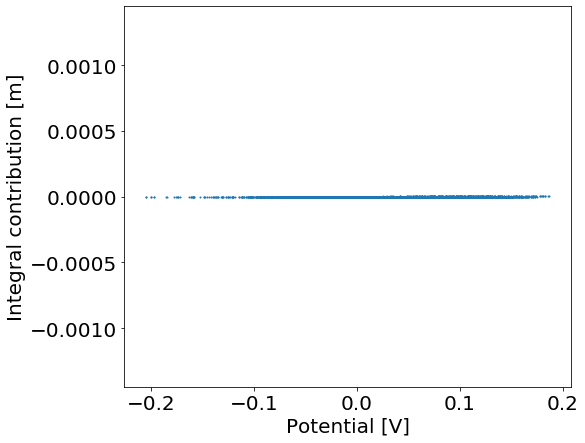

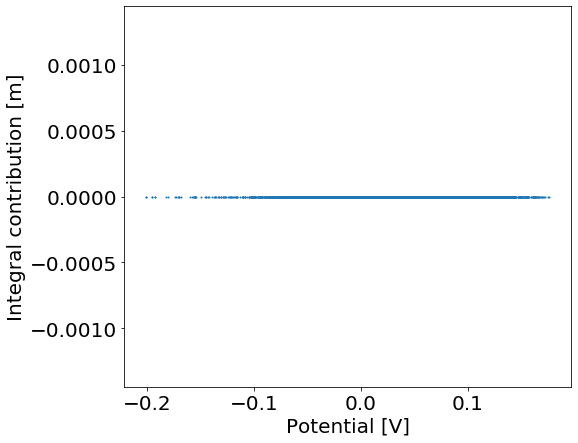

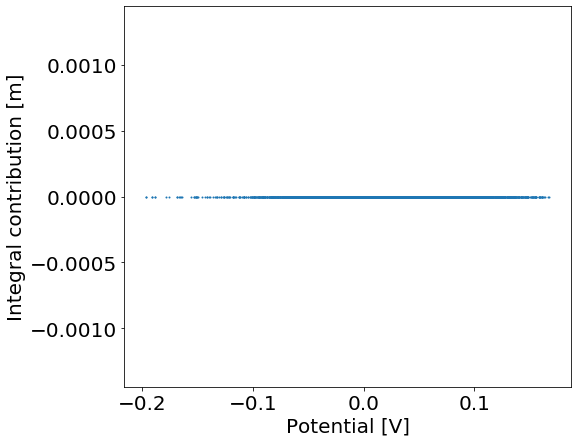

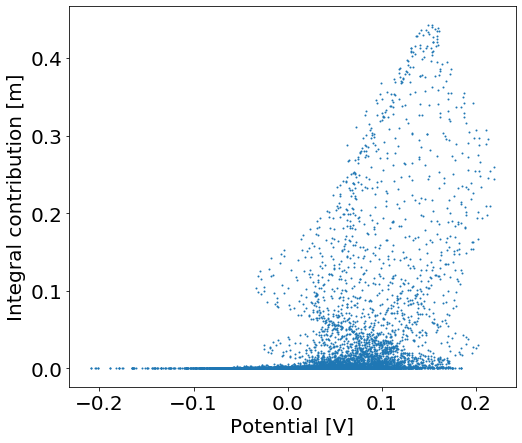

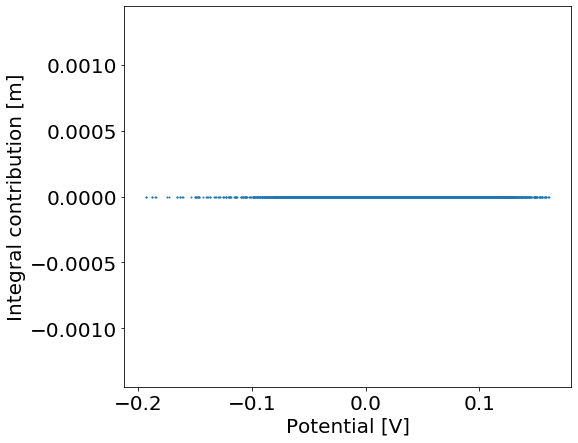

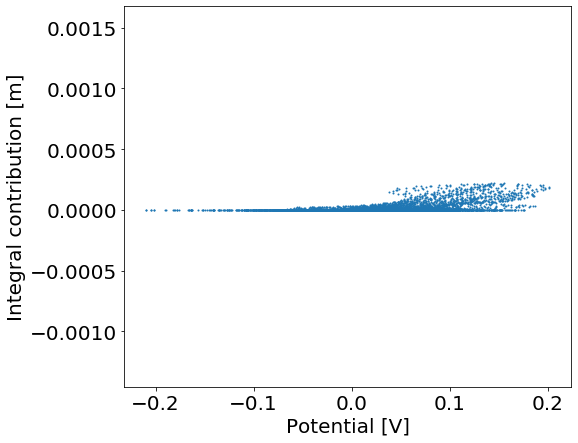

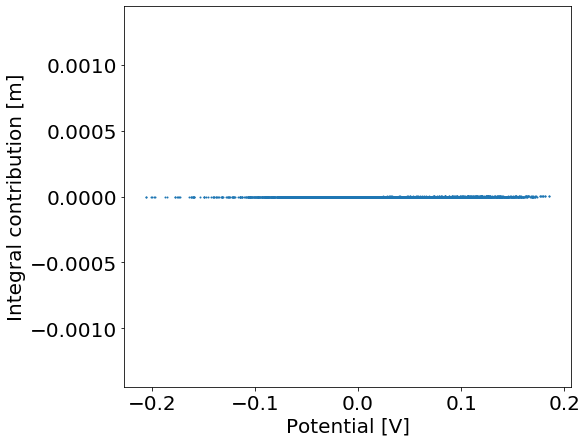

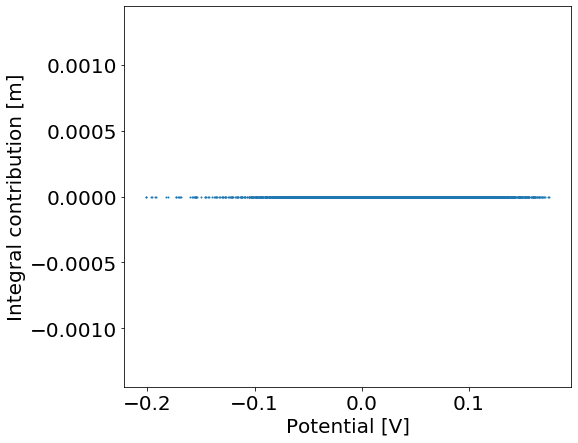

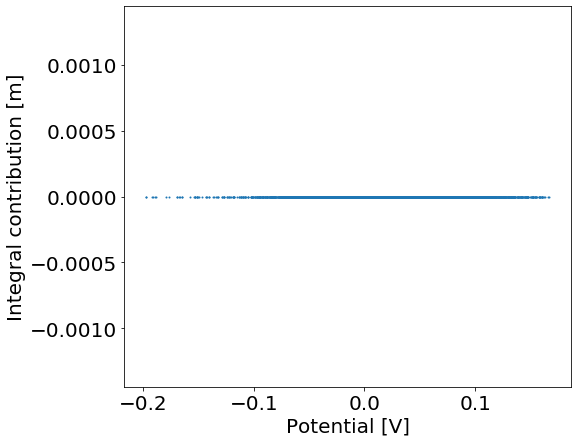

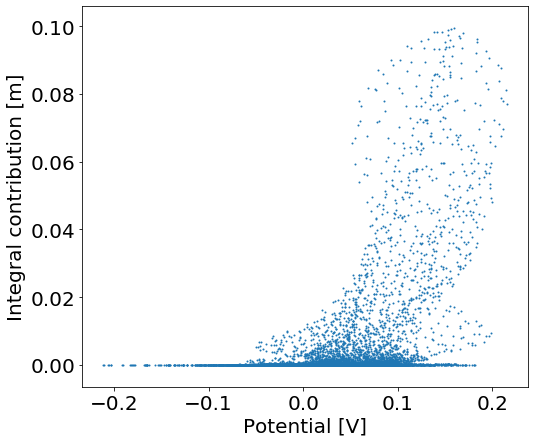

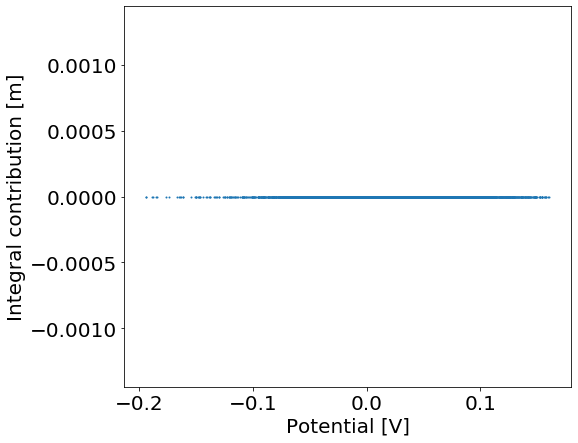

In [30]:
integral_files = os.listdir(integral_dir)
integral_files.sort()

for file in integral_files:
    df = pd.read_csv(integral_dir + file)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight': 'normal', 'size': 20}
    plt.rc('font', **font)
    ax.set_xlabel('Potential [V]')
    ax.set_ylabel('Integral contribution [m]')
#     ax.axhline(color='black')

    ax.scatter(df['potential_V'], df['integral'], s=1)
    fig.savefig(images_dir + 'raw_integral_contribs/' + file[:-4] + '.png', 
                bbox_inches='tight', dpi=300)

# Identification of most attractive orientations

In [44]:
base_names = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7', 'lys_pH_5', 'lys_pH_7', 'lys_pH_9', 
              'ova_pH_7']

### For data based on PDB2PQR partial charges

In [45]:
results_dir = 'results_pqr_partial_charges'
z0          = 3.0e-10 

nsbim_data_dir   = 'ns_bim_spherical/' + results_dir + '/ns_bim_data/'
integrand_dir    = 'ns_bim_spherical/' + results_dir + '/integrand_results/'
integral_dir     = 'ns_bim_spherical/' + results_dir + '/integral_results/'
sum_contribs_dir = 'ns_bim_spherical/' + results_dir + '/summed_integral_contribs/'
images_dir       = 'ns_bim_spherical/' + results_dir + '/images/'

In [47]:
protein_folders = os.listdir(nsbim_data_dir)
protein_folders.sort()
# protein_folders

In [48]:
elements_dict, node_dict, charge_dict = get_elem_and_node_dicts(nsbim_data_dir, 
                                                                protein_folders)
elements_dict = fill_elem_dict(elements_dict, node_dict, protein_folders)

In [98]:
path = './ns_bim_spherical/results_pqr_partial_charges/integral_results/'
files = os.listdir(path)
dict_vals = {}
dict_orient = {}

for f in files:
    dict_vals[f] = pd.read_csv(path + f)
    dict_vals[f].rename(columns={'potential_V':'potential_V_2'}, inplace=True)
    vals = list(dict_vals[f].integral)
    vals.sort()
    cut = vals[-10]
    df_attractive = dict_vals[f][dict_vals[f].integral > cut]
    
    name = f[4:f.find('.')]
    df_element = elements_dict[name]
    
    df_attractive = pd.concat([df_attractive, df_element], axis=1, join='inner')
    df_attractive['potential_diff_V'] = df_attractive.potential_V - df_attractive.potential_V_2
    dict_orient[name] = df_attractive

In [102]:
dict_orient[name]

potential_V_2     integral  node_1_id  node_2_id  node_3_id  \
3556      -0.118672  4197.561743       2064       2068       2067   
3557      -0.117561  4437.925158       2068       2072       2067   
3558      -0.074523  4151.280060       2068       2073       2072   
3602      -0.187174  4441.969665       2063       2067       2066   
3603      -0.186439  4598.487725       2067       2071       2066   
3604      -0.151765  4503.596014       2067       2072       2071   
3605      -0.132877  4134.532677       2072       2077       2071   
3649      -0.193561  4091.802733       2066       2070         86   
3650      -0.196765  4262.422006       2066       2071       2070   

      potential_V  charge_C_m2     x1_nm     y1_nm     z1_nm  ...     x3_nm  \
3556    -0.118672    -0.354157 -0.187827 -0.578073  4.025273  ... -0.339069   
3557    -0.117561    -0.258800 -0.130357 -0.756279  3.997914  ... -0.339069   
3558    -0.074523    -0.122354 -0.130357 -0.756279  3.997914  ... -0.281769   
3602    -0.187174    -0.447225 -0.396631 -0.509296  4.019399  ... -0.546795   
3603    -0.186439    -0.488628 -0.339069 -0.688465  3.997914  ... -0.546795   
3604    -0.151765    -0.343964 -0.339069 -0.688465  3.997914  ... -0.489455   
3605    -0.132877    -0.236705 -0.281769 -0.867196  3.967474  ... -0.489455   
3649    -0.193561    -0.350813 -0.546795 -0.618650  3.986296  ... -0.752932   
3650    -0.196765    -0.526408 -0.546795 -0.618650  3.986296  ... -0.695725   

         y3_nm     z3_nm  x_cent_nm  y_cent_nm  z_cent_nm    n_x_nm    n_y_nm  \
3556 -0.688465  3.997914  -0.219084  -0.674273   4.007034 -0.054837 -0.168770   
3557 -0.688465  3.997914  -0.250398  -0.770647   3.987768 -0.060575 -0.186431   
3558 -0.867196  3.967474  -0.161798  -0.852344   3.975709 -0.040731 -0.212351   
3602 -0.618650  3.986296  -0.427498  -0.605470   4.001203 -0.106014 -0.151900   
3603 -0.618650  3.986296  -0.458439  -0.701815   3.981983 -0.111727 -0.169483   
3604 -0.798329  3.961739  -0.370097  -0.784663   3.975709 -0.091865 -0.195737   
3605 -0.798329  3.961739  -0.401199  -0.881058   3.952419 -0.097717 -0.213748   
3649 -0.547037  3.963094  -0.665151  -0.630947   3.964647 -0.162537 -0.151991   
3650 -0.727154  3.944551  -0.577325  -0.714711   3.964196 -0.142749 -0.178608   

        n_z_nm  potential_diff_V  
3556  0.984129      1.387779e-17  
3557  0.980599     -1.387779e-17  
3558  0.976344      0.000000e+00  
3602  0.982694      0.000000e+00  
3603  0.979180     -2.775558e-17  
3604  0.976344      0.000000e+00  
3605  0.971989      0.000000e+00  
3649  0.974926     -2.775558e-17  
3650  0.973510     -2.775558e-17  

[9 rows x 23 columns]